Выполнила: Андрющенко К.С.

Поэтапная разработка кастомной ResNet18 модели для классификации Tiny ImageNet с анализом влияния различных архитектурных решений на производительность.

Датасет: Tiny ImageNet (200 классов) - выберите 10 классов самостоятельно для работы

Создание датакласса
Реализуйте собственный класс TinyImageNetDataset, наследующий от torch.utils.data.Dataset:

* Метод __init__: инициализация путей к данным, загрузка списка изображений и меток
* Метод __len__: возврат количества примеров в датасете
* Метод __getitem__: загрузка и возврат одного примера (изображение + метка)


- **Dataset** - это класс, который индексирует и возвращает один образец данных
- **DataLoader** - это итератор, который группирует данные в батчи и предоставляет многопроцессную загрузку

### Основные методы Dataset:
- `__init__()` - инициализация, загрузка метаданных
- `__len__()` - возвращает размер датасета
- `__getitem__(idx)` - возвращает элемент по индексу


In [2]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.get_device_name(0))
    x = torch.tensor([1.0, 2.0]).cuda()
    print("Test tensor on GPU:", x)
else:
    print("Все еще CPU... Что-то пошло не так.")

PyTorch version: 2.5.1
CUDA available: True
Device count: 1
Current device: NVIDIA GeForce RTX 4060 Ti
Test tensor on GPU: tensor([1., 2.], device='cuda:0')


In [102]:
from torchvision import transforms, models
from PIL import Image
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.utils.data import Dataset
import os
import random
import numpy as np

In [ ]:

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, max_classes=10):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        if not os.path.exists(self.root_dir):
            raise FileNotFoundError(f"Папки {root_dir} нет простите пожалуйста")
        # все классы
        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            all = [line.strip() for line in f]
        # ID класса в число от 0 до 199
        self.class_names = all[:max_classes]
        valid_classes = set(self.class_names)
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}
        self.samples = []

        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                if cls not in valid_classes:
                    continue
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    # путь к файлу и индекс
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    if cls in valid_classes:
                        label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

Аугментация

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((72, 72)),                    
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
from torch.utils.data import DataLoader
root = "tiny_data/tiny-imagenet-200"

train_dataset = TinyImageNetDataset(root, split='train', transform=transforms.ToTensor())
val_dataset = TinyImageNetDataset(root, split='val', transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)


## Часть 2: Базовая архитектура ResNet18

### Базовый residual блок

```
Input
  ↓
Conv2d(kernel_size=3, padding=1, stride=stride)
  ↓
BatchNorm2d
  ↓
ReLU
  ↓
Conv2d(kernel_size=3, padding=1, stride=1)
  ↓
BatchNorm2d
  ↓
  + ← Skip Connection (с возможностью downsample)
  ↓
ReLU
  ↓
Output
```

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1,  bias=False)
        self.batch1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=1, bias=False)
        self.batch2 = nn.BatchNorm2d(out_channels)
        self.down_sample = nn.Identity()
        if in_channels != out_channels or stride != 1:
            self.down_sample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, stride=stride, kernel_size=1, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
                
            )

    def forward(self, x):
        identity = x
        if self.down_sample is not None:
            identity = self.down_sample(x)
        out = self.conv1(x)
        out = self.batch1(out)
        out = self.relu(out
        )
        # 2 слой
        out = self.conv2(out)
        out = self.batch2(out)
        # должны быть одинаковые размеры
        out += identity
        out = self.relu(out)
        return out

In [7]:
res_block = ResidualBlock(64, 64)
test_input = torch.randn(2, 64, 32, 32)
out = res_block(test_input)

### Реализация ResNet18

```
Input (3, 64, 64)
  ↓
Conv2d(3→64, kernel_size=7, stride=2, padding=3)  # или 3x3, stride=1 для Tiny ImageNet
  ↓
BatchNorm2d
  ↓
ReLU
  ↓
MaxPool2d(kernel_size=3, stride=2, padding=1)  # опционально для Tiny ImageNet
  ↓
Layer1: 2x Basic Block (64 channels)
  ↓
Layer2: 2x Basic Block (128 channels, stride=2 в первом блоке)
  ↓
Layer3: 2x Basic Block (256 channels, stride=2 в первом блоке)
  ↓
Layer4: 2x Basic Block (512 channels, stride=2 в первом блоке)  # ОПЦИОНАЛЬНО
  ↓
AdaptiveAvgPool2d(output_size=(1, 1))
  ↓
Flatten
  ↓
Linear(512 → 10)  # 10 классов
  ↓
Output
```

Ограничение < 5M параметров

In [10]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=3, bias=False)
        self.bath1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        #self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic1 = ResidualBlock(64, 64)
        self.basic2 = ResidualBlock(64, 64)

        self.basic3 = ResidualBlock(64, 128, stride=2)
        self.basic4 = ResidualBlock(128, 128, stride=1)

        self.basic5 = ResidualBlock(128, 256, stride=2)
        self.basic6 = ResidualBlock(256, 256, stride=1)
        # для соответсвия ограничению
        # self.basic7 = ResidualBlock(256, 512, stride=2)
        # self.basic8 = ResidualBlock(512, 512, stride=1)

        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.relu((self.bath1((self.conv1((x))))))
        
        out = self.basic2(self.basic1(out))
        out = self.basic4(self.basic3(out))
        out = self.basic6(self.basic5(out))
        # out = self.basic8(self.basic7(out))
        out = self.avg(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out


In [11]:
test_model = ResNet18(num_classes=10)
test_input = torch.randn(2, 3, 64, 64)
out = test_model(test_input)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Параметров в базовой модели: {count_parameters(test_model):,}")

Параметров в базовой модели: 2,777,674


### Скрипт обучения

Для дальнейшего удобства напишем функцию train, а данные обучения соберем в словарь

In [13]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    model = model.to(device)
    history = {
        'loss_train': [],
        'acc_train': [],
        'loss_val': [],
        'acc_val': []
    }
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_correct / train_total
        
        history['loss_train'].append(avg_train_loss)
        history['acc_train'].append(avg_train_acc)

        # dfkblfwbz
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_correct / val_total
        
        history['loss_val'].append(avg_val_loss)
        history['acc_val'].append(avg_val_acc)

        # ушла эпоха
        print(f'Epoch {epoch+1}: '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')
        print(' ^-^ ' * 60)
    return model, history

In [14]:
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
model = ResNet18(num_classes=10) 
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 30

In [16]:
trained_model, history = train(
    model=model,
    train_loader=train_loader, 
    val_loader=val_loader,    
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    device=device
)

Epoch 1/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.43it/s]


Epoch 1: Train Loss: 1.8277, Train Acc: 0.3656, Val Loss: 1.8000, Val Acc: 0.4080
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 2: Train Loss: 1.5628, Train Acc: 0.4656, Val Loss: 1.8037, Val Acc: 0.4320
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 3: Train Loss: 1.4313, Train Acc: 0.5198, Val Loss: 1.5861, Val Acc: 0.4820
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 4: Train Loss: 1.3435, Train Acc: 0.5454, Val Loss: 1.7868, Val Acc: 0.4560
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 5: Train Loss: 1.2533, Train Acc: 0.5744, Val Loss: 1.4092, Val Acc: 0.5100
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 6: Train Loss: 1.1791, Train Acc: 0.5952, Val Loss: 2.4514, Val Acc: 0.3420
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 7: Train Loss: 1.1187, Train Acc: 0.6166, Val Loss: 1.5126, Val Acc: 0.5380
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 8: Train Loss: 1.0506, Train Acc: 0.6430, Val Loss: 1.2391, Val Acc: 0.5880
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 9: Train Loss: 1.0412, Train Acc: 0.6512, Val Loss: 1.3831, Val Acc: 0.5420
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 10: Train Loss: 0.9542, Train Acc: 0.6726, Val Loss: 1.1005, Val Acc: 0.6060
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.51it/s]


Epoch 11: Train Loss: 0.9012, Train Acc: 0.6912, Val Loss: 2.8913, Val Acc: 0.4380
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 12: Train Loss: 0.8653, Train Acc: 0.7020, Val Loss: 1.6259, Val Acc: 0.5040
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 13: Train Loss: 0.8694, Train Acc: 0.7036, Val Loss: 1.5696, Val Acc: 0.5080
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.39it/s]


Epoch 14: Train Loss: 0.8135, Train Acc: 0.7194, Val Loss: 1.4154, Val Acc: 0.5500
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 15: Train Loss: 0.7512, Train Acc: 0.7376, Val Loss: 1.1915, Val Acc: 0.6160
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.56it/s]


Epoch 16: Train Loss: 0.7455, Train Acc: 0.7462, Val Loss: 1.1981, Val Acc: 0.6060
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 17: Train Loss: 0.7021, Train Acc: 0.7638, Val Loss: 1.4388, Val Acc: 0.5560
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 18: Train Loss: 0.6780, Train Acc: 0.7708, Val Loss: 1.3065, Val Acc: 0.6100
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 19: Train Loss: 0.6197, Train Acc: 0.7918, Val Loss: 1.4453, Val Acc: 0.5880
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 20: Train Loss: 0.6262, Train Acc: 0.7868, Val Loss: 1.0855, Val Acc: 0.6700
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 21: Train Loss: 0.5847, Train Acc: 0.8042, Val Loss: 1.1013, Val Acc: 0.6460
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 22: Train Loss: 0.5598, Train Acc: 0.8082, Val Loss: 1.2975, Val Acc: 0.6200
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 23: Train Loss: 0.5175, Train Acc: 0.8226, Val Loss: 1.4413, Val Acc: 0.5960
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 24: Train Loss: 0.4683, Train Acc: 0.8452, Val Loss: 1.1913, Val Acc: 0.6260
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.00it/s]


Epoch 25: Train Loss: 0.4132, Train Acc: 0.8588, Val Loss: 1.3043, Val Acc: 0.6520
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 26: Train Loss: 0.3776, Train Acc: 0.8750, Val Loss: 1.9240, Val Acc: 0.5820
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 27: Train Loss: 0.3817, Train Acc: 0.8758, Val Loss: 1.4309, Val Acc: 0.5980
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 28: Train Loss: 0.3027, Train Acc: 0.9052, Val Loss: 1.6068, Val Acc: 0.6140
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 29: Train Loss: 0.4011, Train Acc: 0.8674, Val Loss: 1.3842, Val Acc: 0.6380
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]

Epoch 30: Train Loss: 0.2361, Train Acc: 0.9240, Val Loss: 1.6880, Val Acc: 0.5840
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


### Визуализация базовых результатов

Напишем функцию для визуализаци

In [17]:
def plot_history(history):
   
    loss_train_epoch = history['loss_train']
    loss_val_epoch = history['loss_val']
    accuracy_train_epoch = history['acc_train']
    accuracy_val_epoch = history['acc_val']
    
    # эпохи
    epochs_range = range(1, len(loss_train_epoch) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss_train_epoch, label='Train Loss')
    plt.plot(epochs_range, loss_val_epoch, label='Val Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracy_train_epoch, label='Train Acc')
    plt.plot(epochs_range, accuracy_val_epoch, label='Val Acc', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

**Информация о модели**

In [18]:
print(model)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), bias=False)
  (bath1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (basic1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (down_sample): Identity()
  )
  (basic2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [19]:
from torchsummary import summary
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 68, 68]           1,728
       BatchNorm2d-2           [-1, 64, 68, 68]             128
              ReLU-3           [-1, 64, 68, 68]               0
          Identity-4           [-1, 64, 68, 68]               0
            Conv2d-5           [-1, 64, 68, 68]          36,864
       BatchNorm2d-6           [-1, 64, 68, 68]             128
              ReLU-7           [-1, 64, 68, 68]               0
            Conv2d-8           [-1, 64, 68, 68]          36,864
       BatchNorm2d-9           [-1, 64, 68, 68]             128
             ReLU-10           [-1, 64, 68, 68]               0
    ResidualBlock-11           [-1, 64, 68, 68]               0
         Identity-12           [-1, 64, 68, 68]               0
           Conv2d-13           [-1, 64, 68, 68]          36,864
      BatchNorm2d-14           [-1, 64,

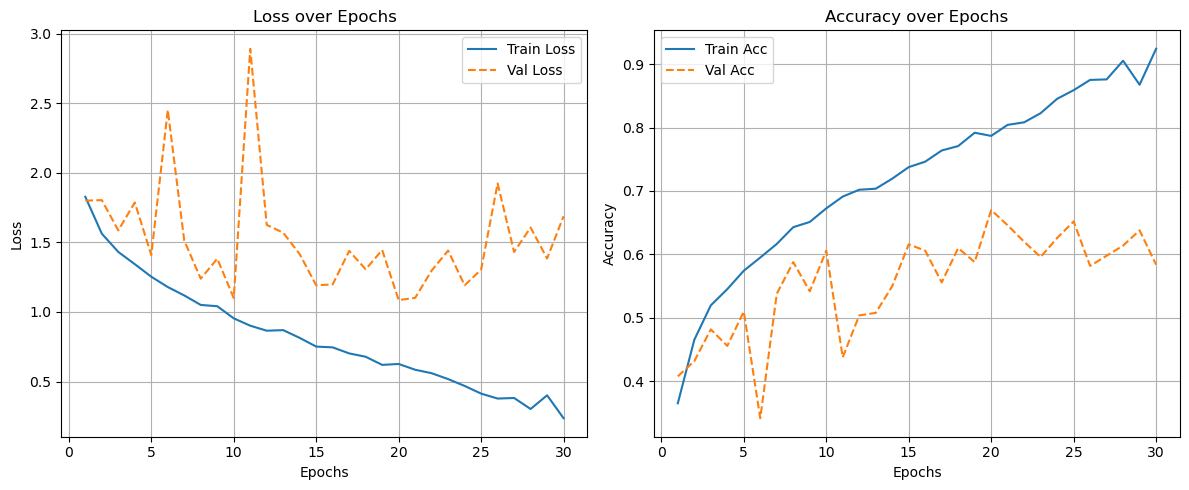

In [21]:
plot_history(history)

## Часть 3: Поэтапная оптимизация модели

### 3.1: Оптимизация количества каналов

Вариант A: 32 → 64 → 128 → 256 каналов

In [22]:
class ResNet18A(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=3, bias=False)
        self.bath1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        #self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic1 = ResidualBlock(32, 32)
        self.basic2 = ResidualBlock(32, 32)

        self.basic3 = ResidualBlock(32, 64, stride=2)
        self.basic4 = ResidualBlock(64, 64, stride=1)

        self.basic5 = ResidualBlock(64, 128, stride=2)
        self.basic6 = ResidualBlock(128, 128, stride=1)
        # для соответсвия ограничению
        self.basic7 = ResidualBlock(128, 256, stride=2)
        self.basic8 = ResidualBlock(256, 256, stride=1)

        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.relu((self.bath1((self.conv1((x))))))
        
        out = self.basic2(self.basic1(out))
        out = self.basic4(self.basic3(out))
        out = self.basic6(self.basic5(out))
        out = self.basic8(self.basic7(out))
        out = self.avg(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out


Вариант B: 64 → 128 → 256 каналов (без 4-го слоя)

In [23]:
class ResNet18B(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=3, bias=False)
        self.bath1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        #self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic1 = ResidualBlock(64, 64)
        self.basic2 = ResidualBlock(64, 64)

        self.basic3 = ResidualBlock(64, 128, stride=2)
        self.basic4 = ResidualBlock(128, 128, stride=1)

        self.basic5 = ResidualBlock(128, 256, stride=2)
        self.basic6 = ResidualBlock(256, 256, stride=1)

        # self.basic7 = ResidualBlock(256, 512, stride=2)
        # self.basic8 = ResidualBlock(512, 512, stride=1)

        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.relu((self.bath1((self.conv1((x))))))
        
        out = self.basic2(self.basic1(out))
        out = self.basic4(self.basic3(out))
        out = self.basic6(self.basic5(out))
        # out = self.basic8(self.basic7(out))
        out = self.avg(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out


Вариант B: 64 → 128 → 256 каналов (без 4-го слоя)

In [25]:
modelB = ResNet18B(num_classes=10)
optimizerB = torch.optim.Adam(modelB.parameters(), lr=0.001)
trained_model_B, history_short_B = train(
    model=modelB,
    train_loader=train_loader, 
    val_loader=val_loader,    
    criterion=criterion,
    optimizer=optimizerB,
    epochs=epochs,
    device=device
)

Epoch 1/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 1: Train Loss: 1.8537, Train Acc: 0.3466, Val Loss: 1.8299, Val Acc: 0.3460
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.51it/s]


Epoch 2: Train Loss: 1.6211, Train Acc: 0.4582, Val Loss: 1.6874, Val Acc: 0.4020
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 3: Train Loss: 1.4819, Train Acc: 0.4936, Val Loss: 1.9342, Val Acc: 0.3840
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 4: Train Loss: 1.3858, Train Acc: 0.5322, Val Loss: 1.7446, Val Acc: 0.4280
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 5: Train Loss: 1.3030, Train Acc: 0.5552, Val Loss: 1.6140, Val Acc: 0.4600
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 6: Train Loss: 1.1981, Train Acc: 0.5990, Val Loss: 1.7242, Val Acc: 0.4640
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 7: Train Loss: 1.1328, Train Acc: 0.6090, Val Loss: 1.4980, Val Acc: 0.5380
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 8: Train Loss: 1.0545, Train Acc: 0.6356, Val Loss: 2.2246, Val Acc: 0.4360
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 9: Train Loss: 1.0005, Train Acc: 0.6522, Val Loss: 2.3358, Val Acc: 0.4820
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.56it/s]


Epoch 10: Train Loss: 0.9780, Train Acc: 0.6680, Val Loss: 1.2434, Val Acc: 0.5960
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 11: Train Loss: 0.9576, Train Acc: 0.6768, Val Loss: 1.3333, Val Acc: 0.5460
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 12: Train Loss: 0.9207, Train Acc: 0.6912, Val Loss: 1.7257, Val Acc: 0.5200
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 13: Train Loss: 0.8795, Train Acc: 0.7006, Val Loss: 2.5904, Val Acc: 0.4780
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 14: Train Loss: 0.8151, Train Acc: 0.7262, Val Loss: 1.3610, Val Acc: 0.5700
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 15: Train Loss: 0.8156, Train Acc: 0.7182, Val Loss: 1.5798, Val Acc: 0.5640
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 16: Train Loss: 0.8047, Train Acc: 0.7212, Val Loss: 1.2881, Val Acc: 0.6220
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 17: Train Loss: 0.7474, Train Acc: 0.7412, Val Loss: 1.2250, Val Acc: 0.5800
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 18: Train Loss: 0.7239, Train Acc: 0.7594, Val Loss: 1.7043, Val Acc: 0.5240
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.39it/s]


Epoch 19: Train Loss: 0.7110, Train Acc: 0.7612, Val Loss: 1.2913, Val Acc: 0.5680
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 20: Train Loss: 0.7110, Train Acc: 0.7642, Val Loss: 1.2369, Val Acc: 0.6080
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 21: Train Loss: 0.6376, Train Acc: 0.7832, Val Loss: 1.2450, Val Acc: 0.6280
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 22: Train Loss: 0.6011, Train Acc: 0.7932, Val Loss: 0.9853, Val Acc: 0.6780
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 23: Train Loss: 0.5546, Train Acc: 0.8160, Val Loss: 1.2610, Val Acc: 0.6460
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 24: Train Loss: 0.5246, Train Acc: 0.8228, Val Loss: 1.7778, Val Acc: 0.5680
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 25: Train Loss: 0.5520, Train Acc: 0.8140, Val Loss: 1.3223, Val Acc: 0.6120
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.56it/s]


Epoch 26: Train Loss: 0.5217, Train Acc: 0.8272, Val Loss: 1.2425, Val Acc: 0.6380
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 27: Train Loss: 0.4840, Train Acc: 0.8398, Val Loss: 2.3206, Val Acc: 0.5380
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 28: Train Loss: 0.4575, Train Acc: 0.8484, Val Loss: 1.4862, Val Acc: 0.5980
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.56it/s]


Epoch 29: Train Loss: 0.4135, Train Acc: 0.8558, Val Loss: 1.3379, Val Acc: 0.6480
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]

Epoch 30: Train Loss: 0.3217, Train Acc: 0.8942, Val Loss: 1.4761, Val Acc: 0.6180
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


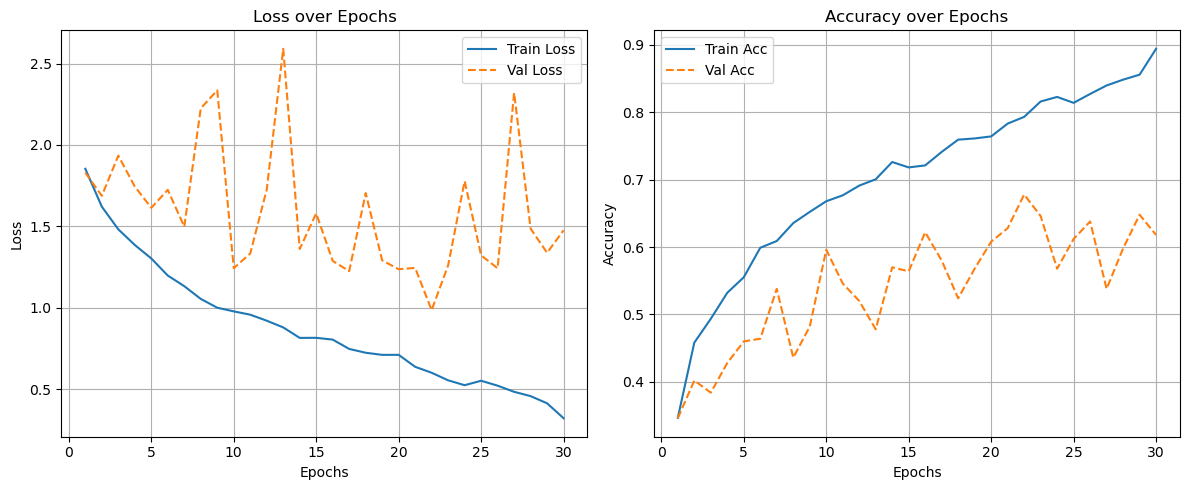

In [26]:
plot_history(history_short_B)

In [27]:
print(trained_model_B)


ResNet18B(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), bias=False)
  (bath1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (basic1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (down_sample): Identity()
  )
  (basic2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [28]:
summary(trained_model_B, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 68, 68]           1,728
       BatchNorm2d-2           [-1, 64, 68, 68]             128
              ReLU-3           [-1, 64, 68, 68]               0
          Identity-4           [-1, 64, 68, 68]               0
            Conv2d-5           [-1, 64, 68, 68]          36,864
       BatchNorm2d-6           [-1, 64, 68, 68]             128
              ReLU-7           [-1, 64, 68, 68]               0
            Conv2d-8           [-1, 64, 68, 68]          36,864
       BatchNorm2d-9           [-1, 64, 68, 68]             128
             ReLU-10           [-1, 64, 68, 68]               0
    ResidualBlock-11           [-1, 64, 68, 68]               0
         Identity-12           [-1, 64, 68, 68]               0
           Conv2d-13           [-1, 64, 68, 68]          36,864
      BatchNorm2d-14           [-1, 64,

In [30]:
print(f"Параметров в базовой модели: {count_parameters(trained_model_B):,}")

Параметров в базовой модели: 2,777,674


Epoch 30: Train Loss: 0.3217, Train Acc: 0.8942, Val Loss: 1.4761, Val Acc: 0.6180

Best Epoch 22: Train Loss: 0.6011, Train Acc: 0.7932, Val Loss: 0.9853, Val Acc: 0.6780

Вариант A: 32 → 64 → 128 → 256 каналов

In [31]:
modelA = ResNet18A(num_classes=10)
optimizerA = torch.optim.Adam(modelA.parameters(), lr=0.001)
trained_model_A, history_short_A = train(
    model=modelA,
    train_loader=train_loader, 
    val_loader=val_loader,    
    criterion=criterion,
    optimizer=optimizerA,
    epochs=epochs,
    device=device
)

Epoch 1/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 33.61it/s]


Epoch 1: Train Loss: 1.8081, Train Acc: 0.3616, Val Loss: 2.2414, Val Acc: 0.3100
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.04it/s]


Epoch 2: Train Loss: 1.5495, Train Acc: 0.4676, Val Loss: 1.5420, Val Acc: 0.4860
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 33.90it/s]


Epoch 3: Train Loss: 1.3853, Train Acc: 0.5308, Val Loss: 1.4957, Val Acc: 0.4900
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 33.06it/s]


Epoch 4: Train Loss: 1.2430, Train Acc: 0.5822, Val Loss: 1.3899, Val Acc: 0.5560
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 33.76it/s]


Epoch 5: Train Loss: 1.1551, Train Acc: 0.6032, Val Loss: 1.7353, Val Acc: 0.4260
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 33.33it/s]


Epoch 6: Train Loss: 1.0892, Train Acc: 0.6274, Val Loss: 1.6766, Val Acc: 0.4880
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.34it/s]


Epoch 7: Train Loss: 1.0130, Train Acc: 0.6580, Val Loss: 1.4676, Val Acc: 0.5580
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.78it/s]


Epoch 8: Train Loss: 0.9690, Train Acc: 0.6698, Val Loss: 1.4413, Val Acc: 0.5500
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.63it/s]


Epoch 9: Train Loss: 0.8849, Train Acc: 0.6960, Val Loss: 1.4800, Val Acc: 0.5380
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 33.90it/s]


Epoch 10: Train Loss: 0.8524, Train Acc: 0.7122, Val Loss: 1.5280, Val Acc: 0.5400
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.04it/s]


Epoch 11: Train Loss: 0.8447, Train Acc: 0.7158, Val Loss: 1.5660, Val Acc: 0.5760
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.93it/s]


Epoch 12: Train Loss: 0.7724, Train Acc: 0.7294, Val Loss: 1.2538, Val Acc: 0.6400
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.48it/s]


Epoch 13: Train Loss: 0.6534, Train Acc: 0.7772, Val Loss: 1.3889, Val Acc: 0.5980
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.33it/s]


Epoch 14: Train Loss: 0.6120, Train Acc: 0.7900, Val Loss: 1.3331, Val Acc: 0.6040
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.19it/s]


Epoch 15: Train Loss: 0.5318, Train Acc: 0.8176, Val Loss: 1.9435, Val Acc: 0.5020
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.04it/s]


Epoch 16: Train Loss: 0.5325, Train Acc: 0.8166, Val Loss: 1.6571, Val Acc: 0.5420
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.48it/s]


Epoch 17: Train Loss: 0.4255, Train Acc: 0.8572, Val Loss: 1.9102, Val Acc: 0.5300
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.19it/s]


Epoch 18: Train Loss: 0.3574, Train Acc: 0.8772, Val Loss: 1.4201, Val Acc: 0.6180
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 33.76it/s]


Epoch 19: Train Loss: 0.2580, Train Acc: 0.9144, Val Loss: 1.7371, Val Acc: 0.5760
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.33it/s]


Epoch 20: Train Loss: 0.2050, Train Acc: 0.9376, Val Loss: 1.3961, Val Acc: 0.6420
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.19it/s]


Epoch 21: Train Loss: 0.1992, Train Acc: 0.9350, Val Loss: 1.5634, Val Acc: 0.6120
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.63it/s]


Epoch 22: Train Loss: 0.1543, Train Acc: 0.9514, Val Loss: 1.6249, Val Acc: 0.6360
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.48it/s]


Epoch 23: Train Loss: 0.0913, Train Acc: 0.9762, Val Loss: 1.5654, Val Acc: 0.6340
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.63it/s]


Epoch 24: Train Loss: 0.1392, Train Acc: 0.9550, Val Loss: 1.7189, Val Acc: 0.6000
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.19it/s]


Epoch 25: Train Loss: 0.0772, Train Acc: 0.9768, Val Loss: 1.7817, Val Acc: 0.6180
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 33.61it/s]


Epoch 26: Train Loss: 0.0578, Train Acc: 0.9874, Val Loss: 2.6546, Val Acc: 0.5560
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.63it/s]


Epoch 27: Train Loss: 0.2851, Train Acc: 0.9048, Val Loss: 1.9863, Val Acc: 0.6120
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.78it/s]


Epoch 28: Train Loss: 0.1569, Train Acc: 0.9536, Val Loss: 1.8155, Val Acc: 0.5820
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.19it/s]


Epoch 29: Train Loss: 0.1093, Train Acc: 0.9674, Val Loss: 1.7877, Val Acc: 0.5640
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 34.48it/s]

Epoch 30: Train Loss: 0.0761, Train Acc: 0.9776, Val Loss: 1.7023, Val Acc: 0.6460
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


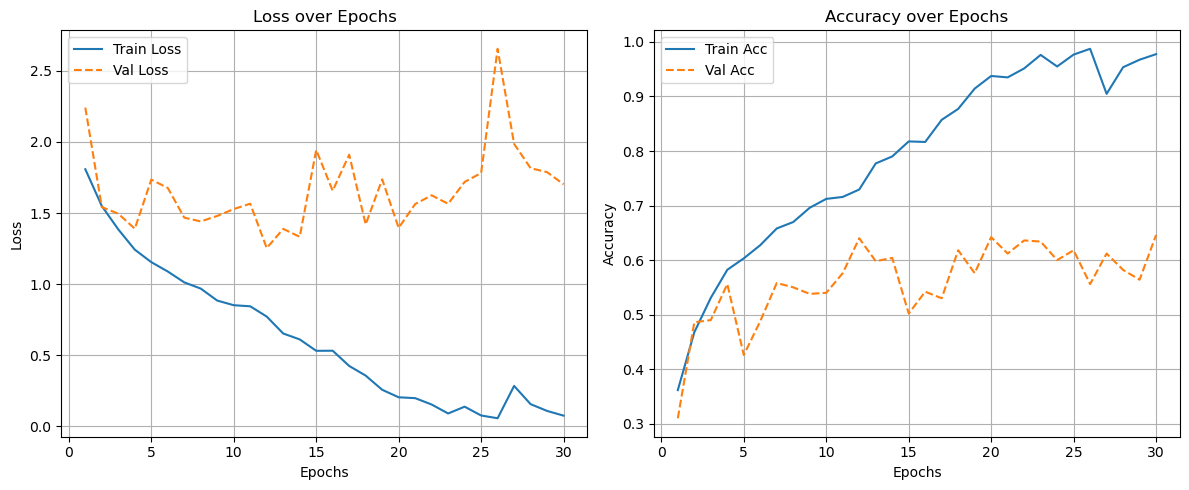

In [32]:
plot_history(history_short_A)

In [33]:
print(f"Параметров в базовой модели: {count_parameters(modelA):,}")

Параметров в базовой модели: 2,797,610


Epoch 30: Train Loss: 0.0761, Train Acc: 0.9776, Val Loss: 1.7023, Val Acc: 0.6460

**Результат**

**Вариант B: 64 → 128 → 256 каналов (без 4-го слоя)**   


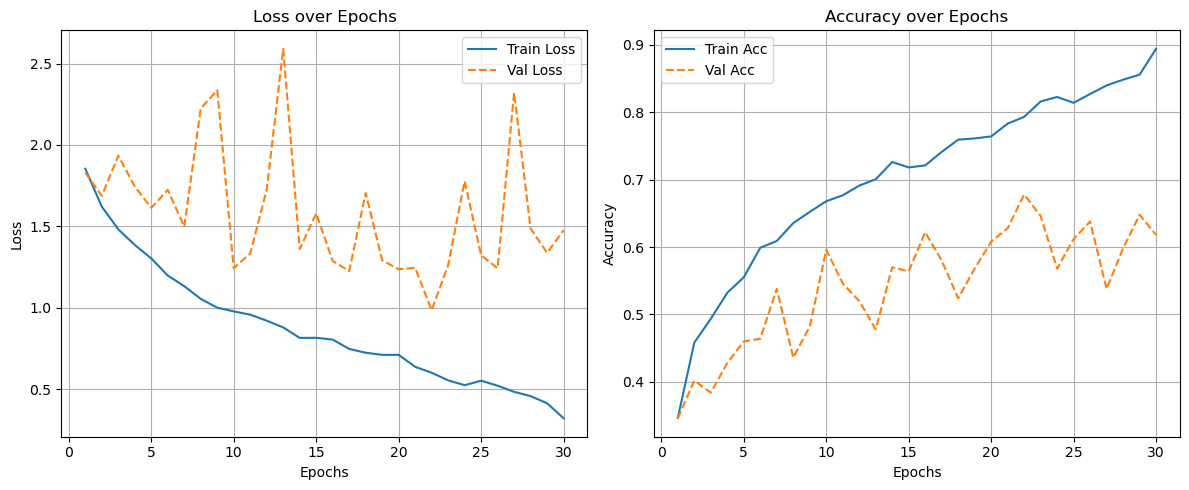

**Вариант A: 32 → 64 → 128 → 256 каналов**  



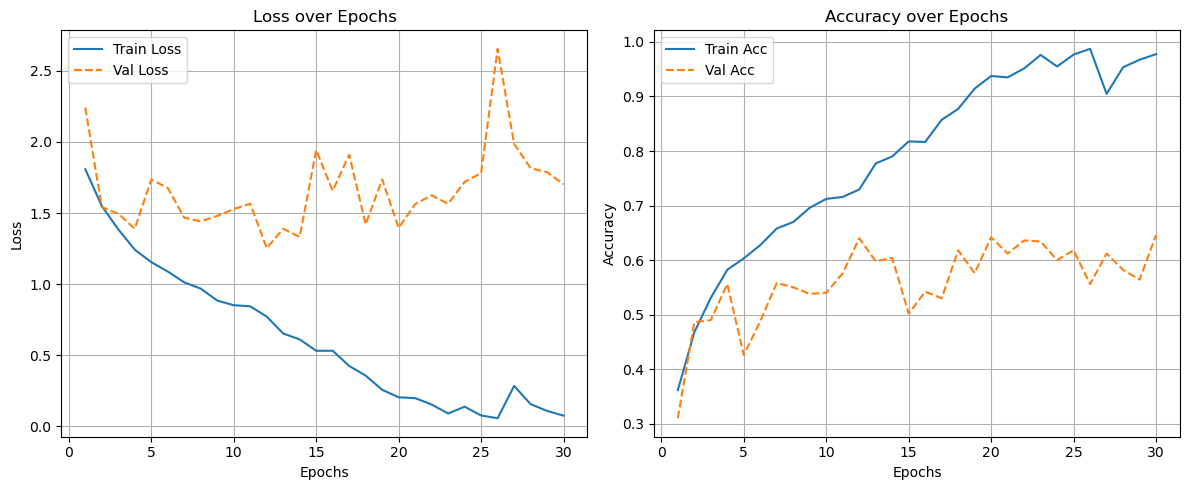

Таблица сравнения

| Этап | Конфигурация | Параметры | Val Accuracy (Best) | Train Accuracy (Last) 
| :--- | :--- | :--- | :--- | :--- |
| 3.1-A | ResNet18A | 2.79 M | 64.60% | 97.30% |
| 3.1-B (Base) | ResNet18B | 2.77 M | 67% | 79.92% |


Вывод: какая конфигурация лучше?

У конфигурации ResNet18A (4 слоя)  присутствует большой разрыв accuracy между train и val. Рост точности на валидации у изначальной модели (3 слоя, меньше параметров) более устойчив, особенно заметно на последних эпохах. Однако маленькая модель менее склонна к переобученю.

### 3.2: Эксперименты с количеством residual блоков

Используйте лучшую конфигурацию каналов из Этапа 3.1: 

Лучшая конфигурация - ResNet18B (3 слоя)

Вариант A: [1, 1, 1, 1] - по 1 блоку в каждом слое (мелкая сеть)

In [36]:
class ResNet18B_smoll(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=3, bias=False)
        self.bath1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        #self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic1 = ResidualBlock(64, 64)
        

        self.basic3 = ResidualBlock(64, 128, stride=2)
        

        self.basic5 = ResidualBlock(128, 256, stride=2)
        

        # self.basic7 = ResidualBlock(256, 512, stride=2)
        

        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.relu((self.bath1((self.conv1((x))))))
        
        out = self.basic1(out)
        out = self.basic3(out)
        out = self.basic5(out)
        # out = self.basic7(out)
        out = self.avg(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out


In [37]:
modelA_smoll = ResNet18B_smoll(num_classes=10)
optimizer_smoll = torch.optim.Adam(modelA_smoll.parameters(), lr=0.001)
trained_model_A_smoll, history_A_smoll = train(
    model=modelA_smoll,
    train_loader=train_loader, 
    val_loader=val_loader,    
    criterion=criterion,
    optimizer=optimizer_smoll,
    epochs=epochs,
    device=device
)

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.89it/s]


Epoch 1: Train Loss: 1.7688, Train Acc: 0.3800, Val Loss: 1.8407, Val Acc: 0.3580
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.19it/s]


Epoch 2: Train Loss: 1.5532, Train Acc: 0.4680, Val Loss: 1.8593, Val Acc: 0.3740
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 29.85it/s]


Epoch 3: Train Loss: 1.3764, Train Acc: 0.5338, Val Loss: 1.4199, Val Acc: 0.4940
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.77it/s]


Epoch 4: Train Loss: 1.2859, Train Acc: 0.5602, Val Loss: 1.5778, Val Acc: 0.4540
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.19it/s]


Epoch 5: Train Loss: 1.1951, Train Acc: 0.5952, Val Loss: 1.5908, Val Acc: 0.5120
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.77it/s]


Epoch 6: Train Loss: 1.1521, Train Acc: 0.6102, Val Loss: 1.8298, Val Acc: 0.4420
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.53it/s]


Epoch 7: Train Loss: 1.1087, Train Acc: 0.6344, Val Loss: 1.5950, Val Acc: 0.5160
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 29.74it/s]


Epoch 8: Train Loss: 1.0646, Train Acc: 0.6388, Val Loss: 1.7381, Val Acc: 0.4740
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 31.01it/s]


Epoch 9: Train Loss: 1.0016, Train Acc: 0.6606, Val Loss: 2.4862, Val Acc: 0.4540
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.65it/s]


Epoch 10: Train Loss: 0.9572, Train Acc: 0.6734, Val Loss: 1.3719, Val Acc: 0.5320
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.65it/s]


Epoch 11: Train Loss: 0.9481, Train Acc: 0.6812, Val Loss: 1.6707, Val Acc: 0.5040
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 31.01it/s]


Epoch 12: Train Loss: 0.9224, Train Acc: 0.6808, Val Loss: 1.8383, Val Acc: 0.5040
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.77it/s]


Epoch 13: Train Loss: 0.8874, Train Acc: 0.7138, Val Loss: 2.0039, Val Acc: 0.5420
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.89it/s]


Epoch 14: Train Loss: 0.8414, Train Acc: 0.7176, Val Loss: 1.8449, Val Acc: 0.4760
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 31.01it/s]


Epoch 15: Train Loss: 0.7996, Train Acc: 0.7312, Val Loss: 1.1223, Val Acc: 0.6500
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 31.13it/s]


Epoch 16: Train Loss: 0.7776, Train Acc: 0.7380, Val Loss: 1.0627, Val Acc: 0.6360
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.65it/s]


Epoch 17: Train Loss: 0.7482, Train Acc: 0.7414, Val Loss: 1.3594, Val Acc: 0.5760
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.53it/s]


Epoch 18: Train Loss: 0.6934, Train Acc: 0.7662, Val Loss: 1.1848, Val Acc: 0.6400
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 31.01it/s]


Epoch 19: Train Loss: 0.6726, Train Acc: 0.7766, Val Loss: 1.4457, Val Acc: 0.5760
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.77it/s]


Epoch 20: Train Loss: 0.6789, Train Acc: 0.7704, Val Loss: 1.1593, Val Acc: 0.6220
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 31.01it/s]


Epoch 21: Train Loss: 0.6104, Train Acc: 0.7986, Val Loss: 1.3335, Val Acc: 0.6120
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 31.13it/s]


Epoch 22: Train Loss: 0.5777, Train Acc: 0.8052, Val Loss: 1.5861, Val Acc: 0.5620
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.53it/s]


Epoch 23: Train Loss: 0.5752, Train Acc: 0.8050, Val Loss: 1.2768, Val Acc: 0.5940
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 31.01it/s]


Epoch 24: Train Loss: 0.5264, Train Acc: 0.8256, Val Loss: 1.8657, Val Acc: 0.5020
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.89it/s]


Epoch 25: Train Loss: 0.4585, Train Acc: 0.8518, Val Loss: 1.6833, Val Acc: 0.5700
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.77it/s]


Epoch 26: Train Loss: 0.4498, Train Acc: 0.8476, Val Loss: 1.1580, Val Acc: 0.6660
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.65it/s]


Epoch 27: Train Loss: 0.3668, Train Acc: 0.8856, Val Loss: 1.9082, Val Acc: 0.5180
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.89it/s]


Epoch 28: Train Loss: 0.3563, Train Acc: 0.8882, Val Loss: 1.5091, Val Acc: 0.5720
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 31.25it/s]


Epoch 29: Train Loss: 0.3000, Train Acc: 0.9084, Val Loss: 1.4910, Val Acc: 0.6060
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 30.77it/s]

Epoch 30: Train Loss: 0.2774, Train Acc: 0.9172, Val Loss: 1.6136, Val Acc: 0.5820
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Вариант B: [2, 2, 2, 2] - по 2 блока в каждом слое (стандартная ResNet18)

In [54]:
modelB = ResNet18B(num_classes=10)
optimizerB = torch.optim.Adam(modelB.parameters(), lr=0.001)
trained_model_B, history_B = train(
    model=modelB,
    train_loader=train_loader, 
    val_loader=val_loader,    
    criterion=criterion,
    optimizer=optimizerB,
    epochs=epochs,
    device=device
)

Epoch 1/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.57it/s]


Epoch 1: Train Loss: 1.8532, Train Acc: 0.3586, Val Loss: 1.8796, Val Acc: 0.3660
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 2: Train Loss: 1.6168, Train Acc: 0.4370, Val Loss: 1.6393, Val Acc: 0.4740
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.45it/s]


Epoch 3: Train Loss: 1.4852, Train Acc: 0.4910, Val Loss: 1.9308, Val Acc: 0.3980
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 4: Train Loss: 1.3942, Train Acc: 0.5164, Val Loss: 1.8348, Val Acc: 0.3920
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 5: Train Loss: 1.2965, Train Acc: 0.5540, Val Loss: 1.6372, Val Acc: 0.4640
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 6: Train Loss: 1.2574, Train Acc: 0.5814, Val Loss: 1.4044, Val Acc: 0.5280
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 7: Train Loss: 1.1445, Train Acc: 0.6048, Val Loss: 1.4201, Val Acc: 0.5260
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 8: Train Loss: 1.0942, Train Acc: 0.6266, Val Loss: 1.4459, Val Acc: 0.5500
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 9: Train Loss: 1.0674, Train Acc: 0.6412, Val Loss: 1.2171, Val Acc: 0.5760
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 10: Train Loss: 1.0162, Train Acc: 0.6556, Val Loss: 1.5154, Val Acc: 0.5060
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.57it/s]


Epoch 11: Train Loss: 0.9926, Train Acc: 0.6586, Val Loss: 1.4467, Val Acc: 0.5500
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 12: Train Loss: 0.9388, Train Acc: 0.6802, Val Loss: 1.5471, Val Acc: 0.5440
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 13: Train Loss: 0.9158, Train Acc: 0.6782, Val Loss: 1.1717, Val Acc: 0.6140
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 14: Train Loss: 0.8427, Train Acc: 0.7144, Val Loss: 1.1786, Val Acc: 0.6080
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.57it/s]


Epoch 15: Train Loss: 0.8218, Train Acc: 0.7198, Val Loss: 1.6389, Val Acc: 0.4020
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 16: Train Loss: 0.7891, Train Acc: 0.7280, Val Loss: 1.3956, Val Acc: 0.5840
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 17: Train Loss: 0.7808, Train Acc: 0.7358, Val Loss: 1.1957, Val Acc: 0.6180
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 18: Train Loss: 0.7656, Train Acc: 0.7382, Val Loss: 1.2690, Val Acc: 0.6240
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.06it/s]


Epoch 19: Train Loss: 0.7447, Train Acc: 0.7468, Val Loss: 1.1736, Val Acc: 0.6240
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 20: Train Loss: 0.6712, Train Acc: 0.7696, Val Loss: 1.1093, Val Acc: 0.6540
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 21: Train Loss: 0.6309, Train Acc: 0.7816, Val Loss: 1.2986, Val Acc: 0.6040
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.45it/s]


Epoch 22: Train Loss: 0.6143, Train Acc: 0.7906, Val Loss: 1.3617, Val Acc: 0.5880
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.34it/s]


Epoch 23: Train Loss: 0.5871, Train Acc: 0.7996, Val Loss: 1.2099, Val Acc: 0.6140
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 24: Train Loss: 0.5477, Train Acc: 0.8102, Val Loss: 2.4755, Val Acc: 0.5180
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 25: Train Loss: 0.5531, Train Acc: 0.8120, Val Loss: 1.1737, Val Acc: 0.6180
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.57it/s]


Epoch 26: Train Loss: 0.5193, Train Acc: 0.8270, Val Loss: 1.3492, Val Acc: 0.6220
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 27: Train Loss: 0.5406, Train Acc: 0.8216, Val Loss: 1.1568, Val Acc: 0.6800
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.57it/s]


Epoch 28: Train Loss: 0.4394, Train Acc: 0.8504, Val Loss: 1.2582, Val Acc: 0.6340
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 29: Train Loss: 0.3934, Train Acc: 0.8742, Val Loss: 1.1176, Val Acc: 0.6680
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.57it/s]

Epoch 30: Train Loss: 0.4190, Train Acc: 0.8588, Val Loss: 1.5453, Val Acc: 0.5660
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Вариант C: [3, 3, 3, 3] - по 3 блока в каждом слое (глубокая сеть)

In [39]:
class ResNet18C(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=3, bias=False)
        self.bath1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        #self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic1 = ResidualBlock(64, 64)
        self.basic2 = ResidualBlock(64, 64)
        self.basic3 = ResidualBlock(64, 64)

        self.basic4 = ResidualBlock(64, 128, stride=2)
        self.basic5 = ResidualBlock(128, 128, stride=1)
        self.basic6 = ResidualBlock(128, 128, stride=1)

        self.basic7 = ResidualBlock(128, 256, stride=2)
        self.basic8 = ResidualBlock(256, 256, stride=1)
        self.basic9 = ResidualBlock(256, 256, stride=1)

        # self.basic10 = ResidualBlock(256, 512, stride=2)
        # self.basic11 = ResidualBlock(512, 512, stride=1)
        # self.basic12 = ResidualBlock(512, 512, stride=1)

        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.relu((self.bath1((self.conv1((x))))))
        
        out = self.basic3(self.basic2(self.basic1(out)))

        out = self.basic6(self.basic5(self.basic4(out))) 

        out = self.basic9(self.basic8(self.basic7(out)))

        # out = self.basic12(self.basic11(self.basic10(out)))

        out = self.avg(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out


In [40]:
modelC = ResNet18C(num_classes=10)
optimizer = torch.optim.Adam(modelC.parameters(), lr=0.001)
trained_model_C, history_C = train(
    model=modelC,
    train_loader=train_loader, 
    val_loader=val_loader,    
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    device=device
)

Epoch 1/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.88it/s]


Epoch 1: Train Loss: 1.9289, Train Acc: 0.3152, Val Loss: 1.8955, Val Acc: 0.3320
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.91it/s]


Epoch 2: Train Loss: 1.6679, Train Acc: 0.4198, Val Loss: 1.9380, Val Acc: 0.3920
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]


Epoch 3: Train Loss: 1.5510, Train Acc: 0.4674, Val Loss: 3.4463, Val Acc: 0.2400
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.81it/s]


Epoch 4: Train Loss: 1.4552, Train Acc: 0.4962, Val Loss: 2.4002, Val Acc: 0.3800
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.81it/s]


Epoch 5: Train Loss: 1.3998, Train Acc: 0.5312, Val Loss: 2.2379, Val Acc: 0.3560
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.84it/s]


Epoch 6: Train Loss: 1.3066, Train Acc: 0.5570, Val Loss: 1.9679, Val Acc: 0.3840
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]


Epoch 7: Train Loss: 1.2265, Train Acc: 0.5718, Val Loss: 1.7948, Val Acc: 0.4580
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.70it/s]


Epoch 8: Train Loss: 1.1822, Train Acc: 0.5904, Val Loss: 2.1717, Val Acc: 0.4280
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.81it/s]


Epoch 9: Train Loss: 1.0987, Train Acc: 0.6222, Val Loss: 1.9149, Val Acc: 0.4760
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.81it/s]


Epoch 10: Train Loss: 1.0810, Train Acc: 0.6246, Val Loss: 1.3432, Val Acc: 0.5660
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]


Epoch 11: Train Loss: 1.0220, Train Acc: 0.6502, Val Loss: 1.6483, Val Acc: 0.5000
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.81it/s]


Epoch 12: Train Loss: 1.0077, Train Acc: 0.6552, Val Loss: 1.3865, Val Acc: 0.5500
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.88it/s]


Epoch 13: Train Loss: 0.9264, Train Acc: 0.6762, Val Loss: 1.7678, Val Acc: 0.5100
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.84it/s]


Epoch 14: Train Loss: 0.9236, Train Acc: 0.6776, Val Loss: 1.2677, Val Acc: 0.5680
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.49it/s]


Epoch 15: Train Loss: 0.8965, Train Acc: 0.6964, Val Loss: 1.3580, Val Acc: 0.5840
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.84it/s]


Epoch 16: Train Loss: 0.8621, Train Acc: 0.7012, Val Loss: 3.4969, Val Acc: 0.3820
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.67it/s]


Epoch 17: Train Loss: 0.8731, Train Acc: 0.7128, Val Loss: 1.7468, Val Acc: 0.5340
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.74it/s]


Epoch 18: Train Loss: 0.8270, Train Acc: 0.7160, Val Loss: 1.2310, Val Acc: 0.6100
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.67it/s]


Epoch 19: Train Loss: 0.7483, Train Acc: 0.7352, Val Loss: 1.5677, Val Acc: 0.5720
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]


Epoch 20: Train Loss: 0.7484, Train Acc: 0.7428, Val Loss: 1.1499, Val Acc: 0.6040
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]


Epoch 21: Train Loss: 0.7069, Train Acc: 0.7630, Val Loss: 1.3832, Val Acc: 0.5600
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.81it/s]


Epoch 22: Train Loss: 0.6609, Train Acc: 0.7734, Val Loss: 1.1871, Val Acc: 0.6180
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]


Epoch 23: Train Loss: 0.6245, Train Acc: 0.7880, Val Loss: 1.1180, Val Acc: 0.6420
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.53it/s]


Epoch 24: Train Loss: 0.6165, Train Acc: 0.7950, Val Loss: 1.1840, Val Acc: 0.6340
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.67it/s]


Epoch 25: Train Loss: 0.6077, Train Acc: 0.7932, Val Loss: 1.3565, Val Acc: 0.5560
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.49it/s]


Epoch 26: Train Loss: 0.5574, Train Acc: 0.8060, Val Loss: 1.7452, Val Acc: 0.5620
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.53it/s]


Epoch 27: Train Loss: 0.5414, Train Acc: 0.8092, Val Loss: 1.0781, Val Acc: 0.6600
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.53it/s]


Epoch 28: Train Loss: 0.5020, Train Acc: 0.8296, Val Loss: 1.7496, Val Acc: 0.5980
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.56it/s]


Epoch 29: Train Loss: 0.4503, Train Acc: 0.8448, Val Loss: 1.6129, Val Acc: 0.6000
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]

Epoch 30: Train Loss: 0.4396, Train Acc: 0.8522, Val Loss: 1.4340, Val Acc: 0.5800
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


**Результат**

Количество параметров

Вариант A: [1, 1, 1, 1] - по 1 блоку в каждом слое (мелкая сеть)

In [94]:
#print(trained_model_A)
summary(trained_model_A, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 68, 68]           1,728
       BatchNorm2d-2           [-1, 64, 68, 68]             128
              ReLU-3           [-1, 64, 68, 68]               0
          Identity-4           [-1, 64, 68, 68]               0
            Conv2d-5           [-1, 64, 68, 68]          36,864
       BatchNorm2d-6           [-1, 64, 68, 68]             128
              ReLU-7           [-1, 64, 68, 68]               0
            Conv2d-8           [-1, 64, 68, 68]          36,864
       BatchNorm2d-9           [-1, 64, 68, 68]             128
             ReLU-10           [-1, 64, 68, 68]               0
    ResidualBlock-11           [-1, 64, 68, 68]               0
           Conv2d-12          [-1, 128, 34, 34]           8,192
      BatchNorm2d-13          [-1, 128, 34, 34]             256
           Conv2d-14          [-1, 128,

Epoch 30: Train Loss: 0.2774, Train Acc: 0.9172, Val Loss: 1.6136, Val Acc: 0.5820

Best Epoch 26: Train Loss: 0.4498, Train Acc: 0.8476, Val Loss: 1.1580, Val Acc: 0.6660

In [44]:
print(f"Параметров в маленькой модели: {count_parameters(trained_model_A_smoll):,}")

Параметров в маленькой модели: 1,227,594


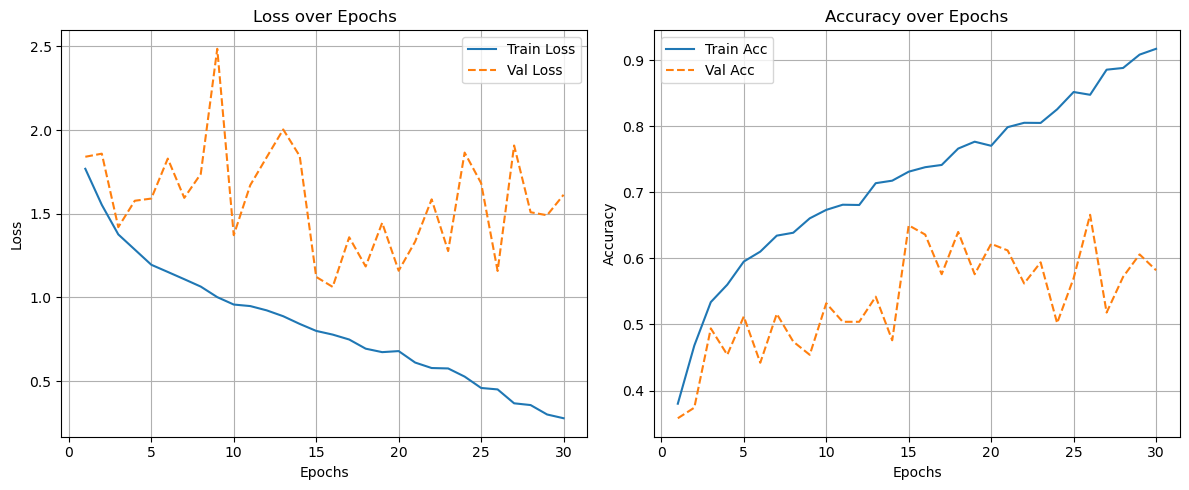

In [43]:
plot_history(history_A_smoll)

Вариант B: [2, 2, 2, 2] - по 2 блока в каждом слое (стандартная ResNet18)

In [55]:
#print(trained_model_B)
summary(trained_model_B, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 68, 68]           1,728
       BatchNorm2d-2           [-1, 64, 68, 68]             128
              ReLU-3           [-1, 64, 68, 68]               0
          Identity-4           [-1, 64, 68, 68]               0
            Conv2d-5           [-1, 64, 68, 68]          36,864
       BatchNorm2d-6           [-1, 64, 68, 68]             128
              ReLU-7           [-1, 64, 68, 68]               0
            Conv2d-8           [-1, 64, 68, 68]          36,864
       BatchNorm2d-9           [-1, 64, 68, 68]             128
             ReLU-10           [-1, 64, 68, 68]               0
    ResidualBlock-11           [-1, 64, 68, 68]               0
         Identity-12           [-1, 64, 68, 68]               0
           Conv2d-13           [-1, 64, 68, 68]          36,864
      BatchNorm2d-14           [-1, 64,

Epoch 30: Train Loss: 0.4190, Train Acc: 0.8588, Val Loss: 1.5453, Val Acc: 0.5660

Best Epoch 27: Train Loss: 0.5406, Train Acc: 0.8216, Val Loss: 1.1568, Val Acc: 0.6800

In [56]:
print(f"Параметров в стандартной модели: {count_parameters(trained_model_B):,}")

Параметров в стандартной модели: 2,777,674


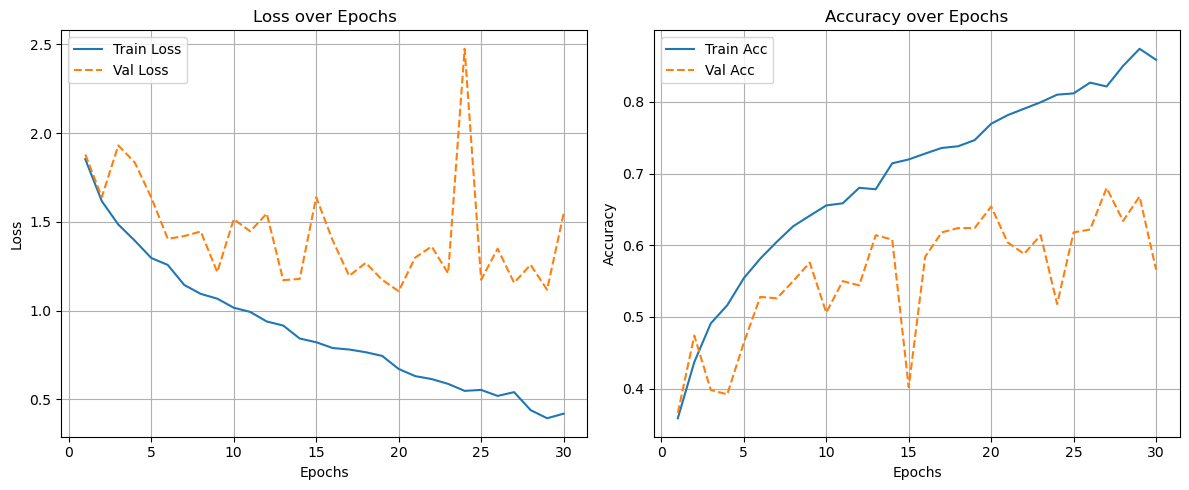

In [57]:
plot_history(history_B)

Вариант C: [3, 3, 3, 3] - по 3 блока в каждом слое (глубокая сеть)

In [96]:
#print(modelC)
summary(trained_model_C, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 68, 68]           1,728
       BatchNorm2d-2           [-1, 64, 68, 68]             128
              ReLU-3           [-1, 64, 68, 68]               0
          Identity-4           [-1, 64, 68, 68]               0
            Conv2d-5           [-1, 64, 68, 68]          36,864
       BatchNorm2d-6           [-1, 64, 68, 68]             128
              ReLU-7           [-1, 64, 68, 68]               0
            Conv2d-8           [-1, 64, 68, 68]          36,864
       BatchNorm2d-9           [-1, 64, 68, 68]             128
             ReLU-10           [-1, 64, 68, 68]               0
    ResidualBlock-11           [-1, 64, 68, 68]               0
         Identity-12           [-1, 64, 68, 68]               0
           Conv2d-13           [-1, 64, 68, 68]          36,864
      BatchNorm2d-14           [-1, 64,

Epoch 30: Train Loss: 0.4396, Train Acc: 0.8522, Val Loss: 1.4340, Val Acc: 0.5800

Best Epoch 27: Train Loss: 0.5414, Train Acc: 0.8092, Val Loss: 1.0781, Val Acc: 0.6600

In [49]:
print(f"Параметров в большогй модели: {count_parameters(trained_model_C):,}")

Параметров в большогй модели: 4,327,754


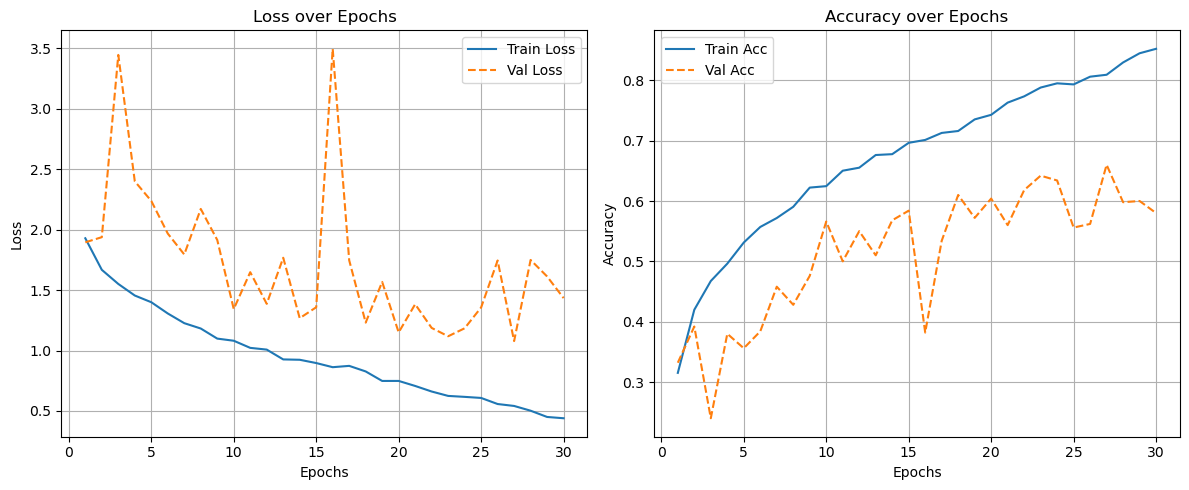

In [50]:
plot_history(history_C)

Validation accuracy. Графики accuracy для всех трех вариантов на одном графике

In [51]:
def plot_accuracy_comparison(histories, model_names):
    plt.figure(figsize=(12, 6))
    for history, name in zip(histories, model_names):
        acc_val = history['acc_val'] 
        epochs_range = range(1, len(acc_val) + 1)
        plt.plot(epochs_range, acc_val, label=f'{name}', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title('Сравнение точности моделей (Validation Accuracy)')
    plt.legend(fontsize='medium')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

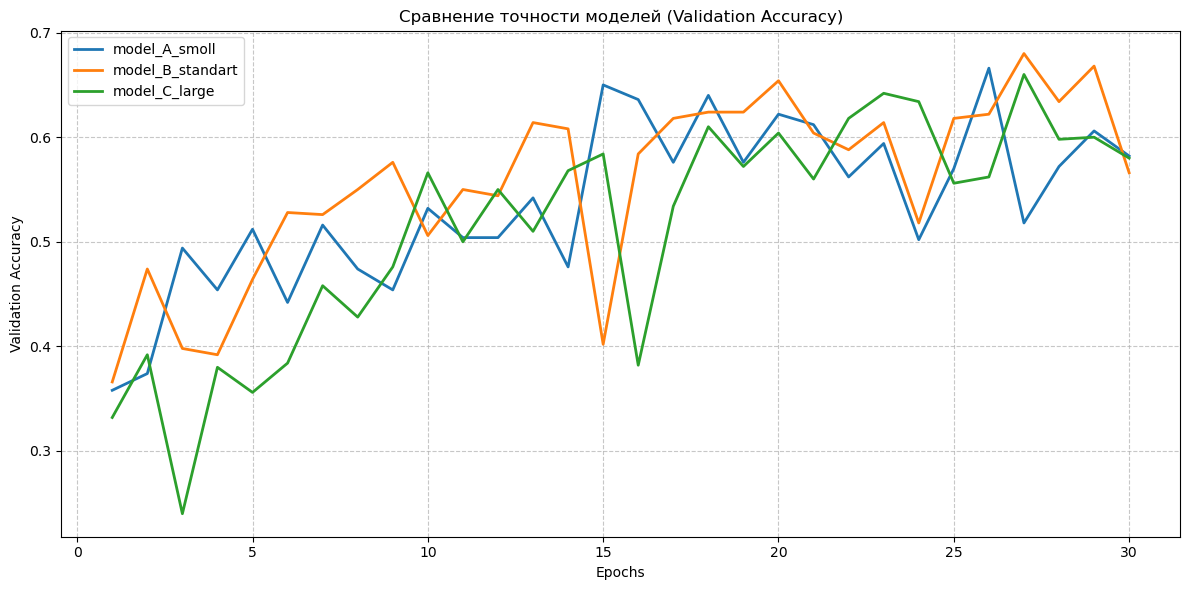

In [58]:
plot_accuracy_comparison([history_A_smoll, history_B, history_C], ['model_A_smoll', 'model_B_standart', 'model_C_large'])

Анализ: какая глубина оптимальна? Есть ли переобучение у более глубоких моделей?

У всех моделей наблюдается большой разрывв между train и val (особеннно после 15 эпохи - переобучение). 
Модель B (8 блоков) показала наилучший результат – 66.40%. Модель B демонстрирует наилучшую способность к обобщению с минимальным разрывом между точностью на обучении и валидации (19.12%). Модель C имеет в 2 раза больше параметров, , но дает лишь на 0.4%.

Вывод: какое количество блоков работает лучше?

| Этап | Конфигурация | Количество блоков | Параметры (M) | Val Accuracy (Best) | Train Accuracy (Last) | Разница (Train - Val) |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 3.2-A | [1, 1, 1, 1] (Мелкая) | 4 | 1.227 | 65.00% | 89.98% | 24.98% |
| 3.2-B | [2, 2, 2, 2] (Стандарт) | 8 | 2.700 | 68.00% | 85.52% | 17.52% |
| 3.2-C | [3, 3, 3, 3] (Глубокая) | 12 | 4.327 | 66.0% | 86.08% | 20.08% |

### 3.3: Эксперименты с функциями активации

Выбранная на предыдущем шаге модель - ResNet18B

Вариант B: LeakyReLU

In [59]:
class ResNet18B_LeakyReLU(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=3, bias=False)
        self.bath1 = nn.BatchNorm2d(64)
        self.relu = nn.LeakyReLU(inplace=True) # 1e-2
        #self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic1 = ResidualBlock(64, 64)
        self.basic2 = ResidualBlock(64, 64)

        self.basic4 = ResidualBlock(64, 128, stride=2)
        self.basic5 = ResidualBlock(128, 128, stride=1)

        self.basic7 = ResidualBlock(128, 256, stride=2)
        self.basic8 = ResidualBlock(256, 256, stride=1)

        # self.basic10 = ResidualBlock(256, 512, stride=2)
        # self.basic11 = ResidualBlock(512, 512, stride=1)

        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.relu((self.bath1((self.conv1((x))))))
        
        out = self.basic2(self.basic1(out))

        out = self.basic5(self.basic4(out))

        out = self.basic8(self.basic7(out))

        # out = self.basic11(self.basic10(out))

        out = self.avg(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out


In [60]:
modelB_LeakyReLU = ResNet18B_LeakyReLU(num_classes=10)
optimizer_LeakyReLU = torch.optim.Adam(modelB_LeakyReLU.parameters(), lr=0.001)
trained_model_B_LeakyReLU, history_B_LeakyReLU = train(
    model=modelB_LeakyReLU,
    train_loader=train_loader, 
    val_loader=val_loader,    
    criterion=criterion,
    optimizer=optimizer_LeakyReLU,
    epochs=epochs,
    device=device
)

Epoch 1/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 1: Train Loss: 1.8453, Train Acc: 0.3578, Val Loss: 1.7777, Val Acc: 0.3760
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.57it/s]


Epoch 2: Train Loss: 1.6132, Train Acc: 0.4396, Val Loss: 2.4661, Val Acc: 0.3080
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 3: Train Loss: 1.4704, Train Acc: 0.5020, Val Loss: 1.6742, Val Acc: 0.4300
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.57it/s]


Epoch 4: Train Loss: 1.3476, Train Acc: 0.5334, Val Loss: 1.8000, Val Acc: 0.4020
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 5: Train Loss: 1.2528, Train Acc: 0.5722, Val Loss: 2.3549, Val Acc: 0.4080
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.17it/s]


Epoch 6: Train Loss: 1.1893, Train Acc: 0.5992, Val Loss: 1.9239, Val Acc: 0.4920
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.78it/s]


Epoch 7: Train Loss: 1.1300, Train Acc: 0.6098, Val Loss: 1.4080, Val Acc: 0.5480
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.95it/s]


Epoch 8: Train Loss: 1.0471, Train Acc: 0.6430, Val Loss: 1.5351, Val Acc: 0.5020
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 9: Train Loss: 1.0056, Train Acc: 0.6560, Val Loss: 1.9954, Val Acc: 0.4660
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.51it/s]


Epoch 10: Train Loss: 0.9465, Train Acc: 0.6772, Val Loss: 1.4876, Val Acc: 0.5360
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 11: Train Loss: 0.9200, Train Acc: 0.6772, Val Loss: 1.3191, Val Acc: 0.5980
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.39it/s]


Epoch 12: Train Loss: 0.8917, Train Acc: 0.6958, Val Loss: 1.3022, Val Acc: 0.5860
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 13: Train Loss: 0.8346, Train Acc: 0.7158, Val Loss: 1.4393, Val Acc: 0.5380
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.57it/s]


Epoch 14: Train Loss: 0.8165, Train Acc: 0.7228, Val Loss: 1.2343, Val Acc: 0.6060
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 15: Train Loss: 0.8034, Train Acc: 0.7334, Val Loss: 1.4057, Val Acc: 0.5720
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 16: Train Loss: 0.7254, Train Acc: 0.7484, Val Loss: 1.1112, Val Acc: 0.6100
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 17: Train Loss: 0.7006, Train Acc: 0.7562, Val Loss: 1.1665, Val Acc: 0.6440
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.92it/s]


Epoch 18: Train Loss: 0.6798, Train Acc: 0.7724, Val Loss: 1.4070, Val Acc: 0.6160
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 19: Train Loss: 0.6153, Train Acc: 0.7852, Val Loss: 1.8172, Val Acc: 0.5380
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 20: Train Loss: 0.6002, Train Acc: 0.7952, Val Loss: 1.1167, Val Acc: 0.6720
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 21: Train Loss: 0.5616, Train Acc: 0.8024, Val Loss: 1.2770, Val Acc: 0.6180
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 22: Train Loss: 0.5456, Train Acc: 0.8170, Val Loss: 1.2600, Val Acc: 0.6420
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 23: Train Loss: 0.4966, Train Acc: 0.8354, Val Loss: 3.7932, Val Acc: 0.4160
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 24: Train Loss: 0.4746, Train Acc: 0.8402, Val Loss: 1.3288, Val Acc: 0.6160
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 25: Train Loss: 0.4269, Train Acc: 0.8590, Val Loss: 1.5557, Val Acc: 0.5900
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 26: Train Loss: 0.3907, Train Acc: 0.8708, Val Loss: 1.4748, Val Acc: 0.5700
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 27: Train Loss: 0.3142, Train Acc: 0.8976, Val Loss: 1.1537, Val Acc: 0.6600
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 28: Train Loss: 0.2792, Train Acc: 0.9102, Val Loss: 1.3589, Val Acc: 0.6540
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 29: Train Loss: 0.3090, Train Acc: 0.9012, Val Loss: 1.6042, Val Acc: 0.6080
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]

Epoch 30: Train Loss: 0.2750, Train Acc: 0.9102, Val Loss: 1.5126, Val Acc: 0.6340
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Вариант C: ELU

In [61]:
class ResNet18B_ELU(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=3, bias=False)
        self.bath1 = nn.BatchNorm2d(64)
        self.relu = nn.ELU(inplace=True) 
        #self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic1 = ResidualBlock(64, 64)
        self.basic2 = ResidualBlock(64, 64)

        self.basic4 = ResidualBlock(64, 128, stride=2)
        self.basic5 = ResidualBlock(128, 128, stride=1)

        self.basic7 = ResidualBlock(128, 256, stride=2)
        self.basic8 = ResidualBlock(256, 256, stride=1)

        # self.basic10 = ResidualBlock(256, 512, stride=2)
        # self.basic11 = ResidualBlock(512, 512, stride=1)

        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.relu((self.bath1((self.conv1((x))))))
        
        out = self.basic2(self.basic1(out))
        out = self.basic5(self.basic4(out))

        out = self.basic8(self.basic7(out))

        # out = self.basic11(self.basic10(out))

        out = self.avg(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out


In [62]:
modelB_ELU = ResNet18B_ELU(num_classes=10)
optimizer_ELU = torch.optim.Adam(modelB_ELU.parameters(), lr=0.001)
trained_model_B_ELU, history_B_ELU = train(
    model=modelB_ELU,
    train_loader=train_loader, 
    val_loader=val_loader,    
    criterion=criterion,
    optimizer=optimizer_ELU,
    epochs=epochs,
    device=device
)

Epoch 1/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 1: Train Loss: 1.8438, Train Acc: 0.3598, Val Loss: 2.0335, Val Acc: 0.3380
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 2: Train Loss: 1.5613, Train Acc: 0.4646, Val Loss: 2.1481, Val Acc: 0.3720
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.92it/s]


Epoch 3: Train Loss: 1.4095, Train Acc: 0.5164, Val Loss: 1.4335, Val Acc: 0.5080
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.98it/s]


Epoch 4: Train Loss: 1.2907, Train Acc: 0.5562, Val Loss: 1.4004, Val Acc: 0.5220
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 5: Train Loss: 1.2009, Train Acc: 0.5932, Val Loss: 1.5546, Val Acc: 0.4660
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 6: Train Loss: 1.1349, Train Acc: 0.6128, Val Loss: 1.6616, Val Acc: 0.4980
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 7: Train Loss: 1.0647, Train Acc: 0.6422, Val Loss: 1.4444, Val Acc: 0.5680
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 8: Train Loss: 0.9931, Train Acc: 0.6582, Val Loss: 1.2408, Val Acc: 0.5920
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.92it/s]


Epoch 9: Train Loss: 0.9680, Train Acc: 0.6656, Val Loss: 1.4263, Val Acc: 0.5260
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 10: Train Loss: 0.9284, Train Acc: 0.6822, Val Loss: 1.1597, Val Acc: 0.6260
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 11: Train Loss: 0.8892, Train Acc: 0.6962, Val Loss: 1.2256, Val Acc: 0.5800
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 12: Train Loss: 0.8523, Train Acc: 0.7000, Val Loss: 1.3284, Val Acc: 0.5760
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.92it/s]


Epoch 13: Train Loss: 0.8144, Train Acc: 0.7206, Val Loss: 1.3364, Val Acc: 0.5860
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 14: Train Loss: 0.7687, Train Acc: 0.7270, Val Loss: 1.2834, Val Acc: 0.6000
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.39it/s]


Epoch 15: Train Loss: 0.7095, Train Acc: 0.7598, Val Loss: 1.5073, Val Acc: 0.5860
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.57it/s]


Epoch 16: Train Loss: 0.6946, Train Acc: 0.7710, Val Loss: 1.5209, Val Acc: 0.5740
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.51it/s]


Epoch 17: Train Loss: 0.6964, Train Acc: 0.7644, Val Loss: 1.5073, Val Acc: 0.5760
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.22it/s]


Epoch 18: Train Loss: 0.6844, Train Acc: 0.7590, Val Loss: 1.2522, Val Acc: 0.6420
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 19: Train Loss: 0.6245, Train Acc: 0.7878, Val Loss: 1.3641, Val Acc: 0.6120
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 20: Train Loss: 0.5677, Train Acc: 0.8026, Val Loss: 1.2274, Val Acc: 0.6160
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.41it/s]


Epoch 21: Train Loss: 0.5480, Train Acc: 0.8162, Val Loss: 1.1204, Val Acc: 0.6760
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 22: Train Loss: 0.5636, Train Acc: 0.8134, Val Loss: 2.1061, Val Acc: 0.5160
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 23: Train Loss: 0.5470, Train Acc: 0.8154, Val Loss: 1.1158, Val Acc: 0.6520
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.57it/s]


Epoch 24: Train Loss: 0.4329, Train Acc: 0.8530, Val Loss: 1.5181, Val Acc: 0.6040
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 25: Train Loss: 0.3883, Train Acc: 0.8654, Val Loss: 1.1627, Val Acc: 0.6640
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.00it/s]


Epoch 26: Train Loss: 0.3643, Train Acc: 0.8768, Val Loss: 1.1863, Val Acc: 0.6840
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.34it/s]


Epoch 27: Train Loss: 0.3316, Train Acc: 0.8956, Val Loss: 1.2419, Val Acc: 0.6600
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.57it/s]


Epoch 28: Train Loss: 0.3311, Train Acc: 0.8884, Val Loss: 1.2060, Val Acc: 0.6680
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.51it/s]


Epoch 29: Train Loss: 0.2830, Train Acc: 0.9054, Val Loss: 1.6010, Val Acc: 0.6240
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]

Epoch 30: Train Loss: 0.2586, Train Acc: 0.9142, Val Loss: 3.3186, Val Acc: 0.4760
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Вариант D: GELU

In [64]:
class ResNet18B_GELU(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=3, bias=False)
        self.bath1 = nn.BatchNorm2d(64)
        self.relu = nn.GELU() 
        #self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic1 = ResidualBlock(64, 64)
        self.basic2 = ResidualBlock(64, 64)

        self.basic4 = ResidualBlock(64, 128, stride=2)
        self.basic5 = ResidualBlock(128, 128, stride=1)

        self.basic7 = ResidualBlock(128, 256, stride=2)
        self.basic8 = ResidualBlock(256, 256, stride=1)

        # self.basic10 = ResidualBlock(256, 512, stride=2)
        # self.basic11 = ResidualBlock(512, 512, stride=1)

        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.relu((self.bath1((self.conv1((x))))))
        
        out = self.basic2(self.basic1(out))

        out = self.basic5(self.basic4(out))

        out = self.basic8(self.basic7(out))

        # out = self.basic11(self.basic10(out))

        out = self.avg(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out


In [66]:
modelB_GELU = ResNet18B_GELU(num_classes=10)
optimizerB_GELU = torch.optim.Adam(modelB_GELU.parameters(), lr=0.001)
trained_model_B_GELU, history_B_GELU = train(
    model=modelB_GELU,
    train_loader=train_loader, 
    val_loader=val_loader,    
    criterion=criterion,
    optimizer=optimizerB_GELU,
    epochs=epochs,
    device=device
)

Epoch 1/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 1: Train Loss: 1.8845, Train Acc: 0.3426, Val Loss: 2.0321, Val Acc: 0.3200
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 2: Train Loss: 1.5907, Train Acc: 0.4410, Val Loss: 2.3882, Val Acc: 0.3000
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 3: Train Loss: 1.5107, Train Acc: 0.4852, Val Loss: 2.5604, Val Acc: 0.2900
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.45it/s]


Epoch 4: Train Loss: 1.3947, Train Acc: 0.5232, Val Loss: 2.1371, Val Acc: 0.3880
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.56it/s]


Epoch 5: Train Loss: 1.2510, Train Acc: 0.5754, Val Loss: 1.3882, Val Acc: 0.5400
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 6: Train Loss: 1.1894, Train Acc: 0.5936, Val Loss: 1.6978, Val Acc: 0.4800
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.45it/s]


Epoch 7: Train Loss: 1.1003, Train Acc: 0.6264, Val Loss: 1.3664, Val Acc: 0.5320
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 8: Train Loss: 1.0715, Train Acc: 0.6316, Val Loss: 1.7692, Val Acc: 0.4720
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 9: Train Loss: 1.0175, Train Acc: 0.6594, Val Loss: 1.4208, Val Acc: 0.5400
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 10: Train Loss: 0.9499, Train Acc: 0.6726, Val Loss: 1.3423, Val Acc: 0.5480
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 11: Train Loss: 0.9081, Train Acc: 0.6912, Val Loss: 1.3076, Val Acc: 0.5880
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 12: Train Loss: 0.8762, Train Acc: 0.7002, Val Loss: 1.1688, Val Acc: 0.6020
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 13: Train Loss: 0.8283, Train Acc: 0.7170, Val Loss: 1.5011, Val Acc: 0.5300
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 14: Train Loss: 0.8023, Train Acc: 0.7390, Val Loss: 1.6481, Val Acc: 0.4880
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 15: Train Loss: 0.7605, Train Acc: 0.7358, Val Loss: 1.6303, Val Acc: 0.5260
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 16: Train Loss: 0.7344, Train Acc: 0.7524, Val Loss: 1.3089, Val Acc: 0.5840
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 17: Train Loss: 0.7174, Train Acc: 0.7586, Val Loss: 1.2232, Val Acc: 0.5940
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s]


Epoch 18: Train Loss: 0.6781, Train Acc: 0.7636, Val Loss: 1.1933, Val Acc: 0.6360
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 19: Train Loss: 0.6402, Train Acc: 0.7780, Val Loss: 1.1890, Val Acc: 0.6020
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


Epoch 20: Train Loss: 0.5805, Train Acc: 0.8046, Val Loss: 1.2414, Val Acc: 0.6020
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 21: Train Loss: 0.5522, Train Acc: 0.8148, Val Loss: 1.1412, Val Acc: 0.6540
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


Epoch 22: Train Loss: 0.5422, Train Acc: 0.8150, Val Loss: 1.2389, Val Acc: 0.6220
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.73it/s]


Epoch 23: Train Loss: 0.4722, Train Acc: 0.8386, Val Loss: 1.5464, Val Acc: 0.6100
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.56it/s]


Epoch 24: Train Loss: 0.4488, Train Acc: 0.8514, Val Loss: 1.4659, Val Acc: 0.5960
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s]


Epoch 25: Train Loss: 0.3941, Train Acc: 0.8630, Val Loss: 1.3816, Val Acc: 0.5980
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.51it/s]


Epoch 26: Train Loss: 0.4034, Train Acc: 0.8684, Val Loss: 1.6266, Val Acc: 0.6040
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.51it/s]


Epoch 27: Train Loss: 0.4120, Train Acc: 0.8648, Val Loss: 2.6128, Val Acc: 0.5020
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]


Epoch 28: Train Loss: 0.3941, Train Acc: 0.8666, Val Loss: 1.3101, Val Acc: 0.6180
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.51it/s]


Epoch 29: Train Loss: 0.2423, Train Acc: 0.9250, Val Loss: 1.4789, Val Acc: 0.6320
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/30 [Val]: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s]

Epoch 30: Train Loss: 0.2684, Train Acc: 0.9124, Val Loss: 1.6777, Val Acc: 0.6120
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


LeakyReLU

Epoch 20: Train Loss: 0.6002, Train Acc: 0.7952, Val Loss: 1.1167, Val Acc: 0.6720

Epoch 30: Train Loss: 0.2750, Train Acc: 0.9102, Val Loss: 1.5126, Val Acc: 0.6340



ELU

Epoch 26: Train Loss: 0.3643, Train Acc: 0.8768, Val Loss: 1.1863, Val Acc: 0.6840

Epoch 30: Train Loss: 0.2586, Train Acc: 0.9142, Val Loss: 3.3186, Val Acc: 0.4760



GELU

Epoch 21: Train Loss: 0.5522, Train Acc: 0.8148, Val Loss: 1.1412, Val Acc: 0.6540

Epoch 30: Train Loss: 0.2684, Train Acc: 0.9124, Val Loss: 1.6777, Val Acc: 0.6120

Результаты без аугментации

| Этап | Конфигурация | Параметры (M) | Val Accuracy (Best) | Train Accuracy (Last) | Разница (Train - Val) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Baseline | ResNet18 Каналы: 64→128→256 (3 слоя) | 2.7 | 67%  | 79.92% | 12.92% |
| 3.1-A | ResNet18A | 2.79 M | 64.60% | 97.30% | 32.7% |
| 3.1-B (Base) | ResNet18B | 2.77 M | 67% | 79.92% | 12.92% |
| 3.2-A | Блоки: [1, 1, 1, 1] (Мелкая) | 1.227 | 65.00% | 89.98% | 24.98% |
| 3.2-B | Блоки: [2, 2, 2, 2] (Стандарт) | 2.7 | 66.40% | 85.52% | 19.12% |
| 3.2-C | Блоки: [3, 3, 3, 3] (Глубокая) | 4.327 | 66.00% | 86.08% | 20.08% |
| 3.3-A | Активация: ReLU (База) | 2.7 | 66.40% | 85.52% | 19.12% |
| 3.3-B | Активация: LeakyReLU | 2.7 | 67.20% | 91.02% | 23.82% |
| 3.3-C | Активация: ELU | 2.7 | 68.40% | 91.42% | 23.02% |
| 3.3-D | Активация: GELU | 2.7 | 65.40% | 91.24% | 25.84% |
| Final | ELU, [2,2,2,2], 64→128→256 | 2.7 | 68.40% | 91.42% | 23.02%  |

### Часть 4: Финальная модель и тестирование

На основании прошлых экспериментов можно протестировать следующие модели:
* 3 слоя
* 2 блока (residual)
* ELU

Добавим аугментацию

In [96]:
train_transform = transforms.Compose([                  
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [97]:
from torch.utils.data import DataLoader
root = "tiny_data/tiny-imagenet-200"

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
val_dataset = TinyImageNetDataset(root, split='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)


In [98]:
model = ResNet18B_ELU(num_classes=10) 
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 40

In [100]:
trained_model_ResNet18B_ELU, history_ResNet18B_ELU = train(
    model=model,
    train_loader=train_loader, 
    val_loader=val_loader,    
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    device=device
)

Epoch 1/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.73it/s]


Epoch 1: Train Loss: 1.9049, Train Acc: 0.3272, Val Loss: 1.8518, Val Acc: 0.3560
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


Epoch 2: Train Loss: 1.7857, Train Acc: 0.3742, Val Loss: 1.8999, Val Acc: 0.3780
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.36it/s]


Epoch 3: Train Loss: 1.7585, Train Acc: 0.3978, Val Loss: 1.9836, Val Acc: 0.3800
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.46it/s]


Epoch 4: Train Loss: 1.7299, Train Acc: 0.3942, Val Loss: 1.7300, Val Acc: 0.4320
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.67it/s]


Epoch 5: Train Loss: 1.6037, Train Acc: 0.4536, Val Loss: 1.7432, Val Acc: 0.4300
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.05it/s]


Epoch 6: Train Loss: 1.5384, Train Acc: 0.4762, Val Loss: 1.5979, Val Acc: 0.4800
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


Epoch 7: Train Loss: 1.4875, Train Acc: 0.4994, Val Loss: 1.7275, Val Acc: 0.4480
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.67it/s]


Epoch 8: Train Loss: 1.4163, Train Acc: 0.5180, Val Loss: 1.8295, Val Acc: 0.4300
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.78it/s]


Epoch 9: Train Loss: 1.3801, Train Acc: 0.5214, Val Loss: 1.5018, Val Acc: 0.5040
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.46it/s]


Epoch 10: Train Loss: 1.3426, Train Acc: 0.5362, Val Loss: 1.4715, Val Acc: 0.4840
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.41it/s]


Epoch 11: Train Loss: 1.3194, Train Acc: 0.5450, Val Loss: 1.3502, Val Acc: 0.5420
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


Epoch 12: Train Loss: 1.2695, Train Acc: 0.5644, Val Loss: 1.5338, Val Acc: 0.5000
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


Epoch 13: Train Loss: 1.2442, Train Acc: 0.5718, Val Loss: 1.4555, Val Acc: 0.5280
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.73it/s]


Epoch 14: Train Loss: 1.2419, Train Acc: 0.5720, Val Loss: 1.4527, Val Acc: 0.5140
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.46it/s]


Epoch 15: Train Loss: 1.2372, Train Acc: 0.5740, Val Loss: 1.3217, Val Acc: 0.5360
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


Epoch 16: Train Loss: 1.2064, Train Acc: 0.5962, Val Loss: 1.2852, Val Acc: 0.5660
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


Epoch 17: Train Loss: 1.1879, Train Acc: 0.5980, Val Loss: 1.2814, Val Acc: 0.5420
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 18.96it/s]


Epoch 18: Train Loss: 1.1637, Train Acc: 0.5962, Val Loss: 1.2553, Val Acc: 0.5780
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.51it/s]


Epoch 19: Train Loss: 1.1564, Train Acc: 0.6016, Val Loss: 1.3366, Val Acc: 0.5480
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


Epoch 20: Train Loss: 1.1300, Train Acc: 0.6050, Val Loss: 1.2540, Val Acc: 0.5420
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.67it/s]


Epoch 21: Train Loss: 1.1141, Train Acc: 0.6274, Val Loss: 1.2951, Val Acc: 0.5620
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.73it/s]


Epoch 22: Train Loss: 1.0776, Train Acc: 0.6268, Val Loss: 1.2905, Val Acc: 0.5520
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


Epoch 23: Train Loss: 1.0806, Train Acc: 0.6282, Val Loss: 1.1920, Val Acc: 0.5740
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.57it/s]


Epoch 24: Train Loss: 1.0555, Train Acc: 0.6418, Val Loss: 1.3418, Val Acc: 0.5340
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.67it/s]


Epoch 25: Train Loss: 1.0402, Train Acc: 0.6408, Val Loss: 1.2996, Val Acc: 0.5700
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.73it/s]


Epoch 26: Train Loss: 1.0250, Train Acc: 0.6464, Val Loss: 1.2006, Val Acc: 0.5980
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.30it/s]


Epoch 27: Train Loss: 1.0313, Train Acc: 0.6484, Val Loss: 1.2139, Val Acc: 0.5760
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.41it/s]


Epoch 28: Train Loss: 1.0031, Train Acc: 0.6554, Val Loss: 1.2674, Val Acc: 0.5940
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.57it/s]


Epoch 29: Train Loss: 0.9864, Train Acc: 0.6614, Val Loss: 1.1263, Val Acc: 0.6240
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.57it/s]


Epoch 30: Train Loss: 0.9823, Train Acc: 0.6592, Val Loss: 1.2422, Val Acc: 0.5600
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 31/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.67it/s]


Epoch 31: Train Loss: 0.9485, Train Acc: 0.6776, Val Loss: 1.2385, Val Acc: 0.5700
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 32/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.51it/s]


Epoch 32: Train Loss: 0.9812, Train Acc: 0.6596, Val Loss: 1.1567, Val Acc: 0.6020
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 33/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.67it/s]


Epoch 33: Train Loss: 0.9732, Train Acc: 0.6608, Val Loss: 1.2497, Val Acc: 0.5860
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 34/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


Epoch 34: Train Loss: 0.9334, Train Acc: 0.6762, Val Loss: 1.1549, Val Acc: 0.6060
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 35/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


Epoch 35: Train Loss: 0.9363, Train Acc: 0.6862, Val Loss: 1.3678, Val Acc: 0.5500
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 36/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


Epoch 36: Train Loss: 0.9492, Train Acc: 0.6736, Val Loss: 1.1549, Val Acc: 0.5980
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 37/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


Epoch 37: Train Loss: 0.9460, Train Acc: 0.6718, Val Loss: 1.1724, Val Acc: 0.6080
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 38/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.73it/s]


Epoch 38: Train Loss: 0.9185, Train Acc: 0.6938, Val Loss: 1.1307, Val Acc: 0.6360
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 39/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.67it/s]


Epoch 39: Train Loss: 0.9173, Train Acc: 0.6942, Val Loss: 1.1350, Val Acc: 0.5960
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 40/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.25it/s]

Epoch 40: Train Loss: 0.8803, Train Acc: 0.6994, Val Loss: 1.1785, Val Acc: 0.6200
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Best Epoch 37: Train Loss: 0.7099, Train Acc: 0.7604, Val Loss: 1.0238, Val Acc: 0.6700


Epoch 40: Train Loss: 0.6796, Train Acc: 0.7668, Val Loss: 1.2675, Val Acc: 0.6340

Добавление ранней остановки

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device, patience=7, model_path='best_model.pt'):
    model = model.to(device)
    best_val_acc = 0.0
    patience_counter = 0
    
    history = {
        'loss_train': [],
        'acc_train': [],
        'loss_val': [],
        'acc_val': []
    }
    torch.save(model.state_dict(), model_path) 
    
    for epoch in range(epochs):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
    
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_correct / train_total
        
        history['loss_train'].append(avg_train_loss)
        history['acc_train'].append(avg_train_acc)
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_correct / val_total
        
        history['loss_val'].append(avg_val_loss)
        history['acc_val'].append(avg_val_acc)
        
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            patience_counter = 0

            torch.save(model.state_dict(), model_path)
            print(f'New best Val Acc: {best_val_acc:.4f}. Model weights saved to {model_path}')
        else:
            patience_counter += 1
            
            if patience_counter >= patience:
                print(f"*** EARLY STOPPING  {epoch+1}. Best Val Acc: {best_val_acc:.4f} ***")
                break 

        print(f'Epoch {epoch+1}: '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')
        print(' ^-^ ' * 10)
        
    model.load_state_dict(torch.load(model_path))
    
    return model, history

In [107]:
trained_model_final, history_final = train(
    model=model,
    train_loader=train_loader, 
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=40, 
    device=device,
    patience=7, 
    model_path='final_elu_best.pt'
)

Epoch 1/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 19.95it/s]


New best Val Acc: 0.6460. Model weights saved to final_elu_best.pt
Epoch 1: Train Loss: 0.8811, Train Acc: 0.6954, Val Loss: 1.1055, Val Acc: 0.6460
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 19.75it/s]


Epoch 2: Train Loss: 0.8851, Train Acc: 0.6946, Val Loss: 1.2122, Val Acc: 0.6060
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.36it/s]


Epoch 3: Train Loss: 0.8806, Train Acc: 0.6960, Val Loss: 1.2522, Val Acc: 0.6080
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 19.85it/s]


New best Val Acc: 0.6500. Model weights saved to final_elu_best.pt
Epoch 4: Train Loss: 0.8730, Train Acc: 0.7014, Val Loss: 1.0557, Val Acc: 0.6500
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 19.28it/s]


Epoch 5: Train Loss: 0.8439, Train Acc: 0.7112, Val Loss: 1.1814, Val Acc: 0.6120
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.20it/s]


Epoch 6: Train Loss: 0.8402, Train Acc: 0.7108, Val Loss: 1.0846, Val Acc: 0.6280
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.00it/s]


Epoch 7: Train Loss: 0.8348, Train Acc: 0.7126, Val Loss: 1.1166, Val Acc: 0.6480
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.05it/s]


Epoch 8: Train Loss: 0.8192, Train Acc: 0.7236, Val Loss: 1.2492, Val Acc: 0.5980
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.57it/s]


Epoch 9: Train Loss: 0.8157, Train Acc: 0.7210, Val Loss: 1.1257, Val Acc: 0.6280
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.57it/s]


New best Val Acc: 0.6520. Model weights saved to final_elu_best.pt
Epoch 10: Train Loss: 0.8181, Train Acc: 0.7182, Val Loss: 1.0027, Val Acc: 0.6520
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.36it/s]


Epoch 11: Train Loss: 0.8411, Train Acc: 0.7100, Val Loss: 1.1439, Val Acc: 0.6120
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.46it/s]


Epoch 12: Train Loss: 0.8136, Train Acc: 0.7226, Val Loss: 1.1019, Val Acc: 0.6200
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.41it/s]


Epoch 13: Train Loss: 0.7831, Train Acc: 0.7336, Val Loss: 1.0966, Val Acc: 0.6320
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.57it/s]


Epoch 14: Train Loss: 0.7747, Train Acc: 0.7394, Val Loss: 1.1713, Val Acc: 0.6180
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.46it/s]


Epoch 15: Train Loss: 0.8358, Train Acc: 0.7214, Val Loss: 1.2264, Val Acc: 0.6060
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.46it/s]


Epoch 16: Train Loss: 0.7743, Train Acc: 0.7280, Val Loss: 1.0649, Val Acc: 0.6400
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/40 [Val]: 100%|██████████| 8/8 [00:00<00:00, 20.51it/s]

*** EARLY STOPPING triggered at epoch 17. Val Acc did not improve for 7 epochs. Best Val Acc: 0.6520 ***



C:\Users\Xenia\AppData\Local\Temp\ipykernel_12548\1092489581.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Попробуем сменить оптимизатор и добавить измнение размера шага оптимизатора

In [85]:
model = ResNet18B_ELU(num_classes=10) 
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='max', 
#     factor=0.5, 
#     patience=5, 
#     verbose=True
# )

In [79]:
def train_tiny(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device, use_mixup=False, mixup_alpha=0.2):
    model = model.to(device)
    history = {
        'loss_train': [],
        'acc_train': [],
        'loss_val': [],
        'acc_val': []
    }
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
    
            _, predicted = torch.max(output.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_correct / train_total
        
        history['loss_train'].append(avg_train_loss)
        history['acc_train'].append(avg_train_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_correct / val_total
        
        history['loss_val'].append(avg_val_loss)
        history['acc_val'].append(avg_val_acc)
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_acc)
            else:
                scheduler.step()

        print(f'Epoch {epoch+1}: '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')
        print(' ^-^ ' * 60)
        
    return model, history

In [86]:
trained_model, history = train_tiny(
    model=model,
    train_loader=train_loader, 
    val_loader=val_loader,    
    criterion=criterion,
    optimizer=optimizer,
    scheduler=None,
    epochs=epochs,
    device=device
)

Epoch 1/40: 100%|██████████| 79/79 [00:12<00:00,  6.53it/s]


Epoch 1: Train Loss: 2.0680, Train Acc: 0.2816, Val Loss: 1.9849, Val Acc: 0.3220
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/40: 100%|██████████| 79/79 [00:11<00:00,  6.66it/s]


Epoch 2: Train Loss: 1.8897, Train Acc: 0.3414, Val Loss: 1.9993, Val Acc: 0.2980
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/40: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s]


Epoch 3: Train Loss: 1.8067, Train Acc: 0.3726, Val Loss: 1.7402, Val Acc: 0.3820
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/40: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s]


Epoch 4: Train Loss: 1.7313, Train Acc: 0.4102, Val Loss: 1.6982, Val Acc: 0.4340
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/40: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Epoch 5: Train Loss: 1.6182, Train Acc: 0.4408, Val Loss: 1.7317, Val Acc: 0.4400
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/40: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s]


Epoch 6: Train Loss: 1.5583, Train Acc: 0.4712, Val Loss: 1.6017, Val Acc: 0.4700
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/40: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Epoch 7: Train Loss: 1.5057, Train Acc: 0.4824, Val Loss: 1.5317, Val Acc: 0.4940
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/40: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Epoch 8: Train Loss: 1.4461, Train Acc: 0.5090, Val Loss: 1.5198, Val Acc: 0.4820
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/40: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s]


Epoch 9: Train Loss: 1.4034, Train Acc: 0.5336, Val Loss: 1.4475, Val Acc: 0.4940
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/40: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Epoch 10: Train Loss: 1.3703, Train Acc: 0.5296, Val Loss: 1.4065, Val Acc: 0.5500
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/40: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s]


Epoch 11: Train Loss: 1.3074, Train Acc: 0.5486, Val Loss: 1.4710, Val Acc: 0.4980
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/40: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s]


Epoch 12: Train Loss: 1.3086, Train Acc: 0.5536, Val Loss: 1.3941, Val Acc: 0.5380
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/40: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Epoch 13: Train Loss: 1.2693, Train Acc: 0.5606, Val Loss: 1.3577, Val Acc: 0.5500
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/40: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Epoch 14: Train Loss: 1.2421, Train Acc: 0.5794, Val Loss: 1.2537, Val Acc: 0.5560
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/40: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s]


Epoch 15: Train Loss: 1.2180, Train Acc: 0.5820, Val Loss: 1.3054, Val Acc: 0.5480
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/40: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s]


Epoch 16: Train Loss: 1.1908, Train Acc: 0.5950, Val Loss: 1.5152, Val Acc: 0.5000
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/40: 100%|██████████| 79/79 [00:11<00:00,  6.71it/s]


Epoch 17: Train Loss: 1.1710, Train Acc: 0.5958, Val Loss: 1.4898, Val Acc: 0.4940
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/40: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s]


Epoch 18: Train Loss: 1.1338, Train Acc: 0.6078, Val Loss: 1.2562, Val Acc: 0.5780
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/40: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Epoch 19: Train Loss: 1.1245, Train Acc: 0.6168, Val Loss: 1.3629, Val Acc: 0.5660
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/40: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s]


Epoch 20: Train Loss: 1.1347, Train Acc: 0.6172, Val Loss: 1.4053, Val Acc: 0.5140
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/40: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Epoch 21: Train Loss: 1.1120, Train Acc: 0.6202, Val Loss: 1.2132, Val Acc: 0.5980
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/40: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Epoch 22: Train Loss: 1.0883, Train Acc: 0.6316, Val Loss: 1.1627, Val Acc: 0.6180
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/40: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Epoch 23: Train Loss: 1.0806, Train Acc: 0.6404, Val Loss: 1.2696, Val Acc: 0.5780
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/40: 100%|██████████| 79/79 [00:12<00:00,  6.56it/s]


Epoch 24: Train Loss: 1.0675, Train Acc: 0.6254, Val Loss: 1.2442, Val Acc: 0.5860
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/40: 100%|██████████| 79/79 [00:12<00:00,  6.48it/s]


Epoch 25: Train Loss: 1.0324, Train Acc: 0.6484, Val Loss: 1.2705, Val Acc: 0.5560
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/40: 100%|██████████| 79/79 [00:23<00:00,  3.30it/s]


Epoch 26: Train Loss: 1.0342, Train Acc: 0.6508, Val Loss: 1.2779, Val Acc: 0.5920
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/40: 100%|██████████| 79/79 [00:21<00:00,  3.59it/s]


Epoch 27: Train Loss: 1.0186, Train Acc: 0.6518, Val Loss: 1.2949, Val Acc: 0.5660
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/40: 100%|██████████| 79/79 [00:12<00:00,  6.58it/s]


Epoch 28: Train Loss: 1.0323, Train Acc: 0.6518, Val Loss: 1.2974, Val Acc: 0.5600
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/40: 100%|██████████| 79/79 [00:11<00:00,  6.64it/s]


Epoch 29: Train Loss: 1.0009, Train Acc: 0.6636, Val Loss: 1.2856, Val Acc: 0.5800
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/40: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s]


Epoch 30: Train Loss: 0.9977, Train Acc: 0.6556, Val Loss: 1.2735, Val Acc: 0.5820
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 31/40: 100%|██████████| 79/79 [00:11<00:00,  6.62it/s]


Epoch 31: Train Loss: 0.9771, Train Acc: 0.6666, Val Loss: 1.0927, Val Acc: 0.6100
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 32/40: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s]


Epoch 32: Train Loss: 0.9547, Train Acc: 0.6778, Val Loss: 1.2781, Val Acc: 0.6000
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 33/40: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s]


Epoch 33: Train Loss: 0.9826, Train Acc: 0.6756, Val Loss: 1.2697, Val Acc: 0.5700
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 34/40: 100%|██████████| 79/79 [00:11<00:00,  6.61it/s]


Epoch 34: Train Loss: 0.9368, Train Acc: 0.6826, Val Loss: 1.2848, Val Acc: 0.5860
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 35/40: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s]


Epoch 35: Train Loss: 0.9545, Train Acc: 0.6774, Val Loss: 1.3275, Val Acc: 0.5600
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 36/40: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]


Epoch 36: Train Loss: 0.9652, Train Acc: 0.6762, Val Loss: 1.2811, Val Acc: 0.5760
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 37/40: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s]


Epoch 37: Train Loss: 0.9407, Train Acc: 0.6772, Val Loss: 1.1779, Val Acc: 0.6060
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 38/40: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s]


Epoch 38: Train Loss: 0.9283, Train Acc: 0.6850, Val Loss: 1.1696, Val Acc: 0.6220
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 39/40: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s]


Epoch 39: Train Loss: 0.8984, Train Acc: 0.6940, Val Loss: 1.1513, Val Acc: 0.6200
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 40/40: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s]


Epoch 40: Train Loss: 0.8920, Train Acc: 0.6976, Val Loss: 1.2095, Val Acc: 0.5800
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


bEST Epoch 38: Train Loss: 0.9283, Train Acc: 0.6850, Val Loss: 1.1696, Val Acc: 0.6220

Результаты с ```scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
     optimizer, 
     mode='max', 
     factor=0.5, 
     patience=5, 
     verbose=True
 ) ```
 были ниже

Оцените на test set (на test меток нет, оценим на валидации):  
* Accuracy
* Precision, Recall, F1-score для каждого класса
* Confusion Matri

In [87]:
def evaluate_model(model, loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    # 2. Матрица ошибок (Confusion Matrix)
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


class_names = list(train_dataset.class_to_idx.keys()) 



Evaluating: 100%|██████████| 8/8 [00:00<00:00, 12.92it/s]



Classification Report:
              precision    recall  f1-score   support

   n02124075     0.8000    0.4800    0.6000        50
   n04067472     0.5263    0.4000    0.4545        50
   n04540053     0.5862    0.6800    0.6296        50
   n04099969     0.5333    0.8000    0.6400        50
   n07749582     0.8148    0.8800    0.8462        50
   n01641577     0.8182    0.7200    0.7660        50
   n02802426     0.5102    0.5000    0.5051        50
   n09246464     0.6812    0.9400    0.7899        50
   n07920052     0.9487    0.7400    0.8315        50
   n03970156     0.4318    0.3800    0.4043        50

    accuracy                         0.6520       500
   macro avg     0.6651    0.6520    0.6467       500
weighted avg     0.6651    0.6520    0.6467       500



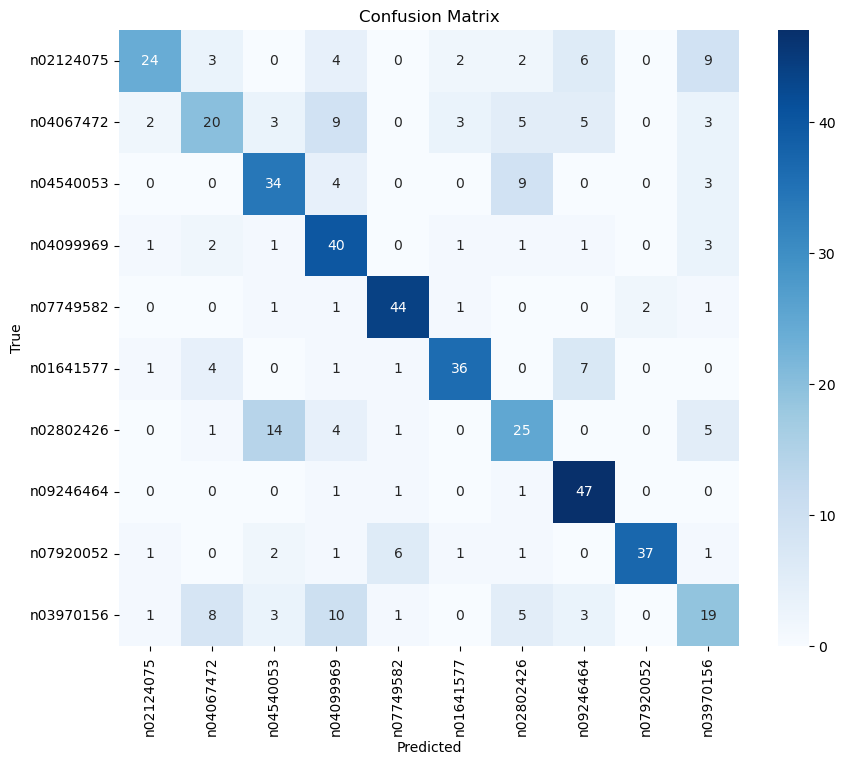

In [108]:
# evaluate_model(trained_model_ResNet18B_ELU, val_loader, device, class_names)
evaluate_model(trained_model_final, val_loader, device, class_names)

n02124075	Egyptian cat      
n04067472	reel   
n04540053	volleyball
n04099969	rocking chair, rocker   
n07749582	lemon   
n01641577	bullfrog, Rana catesbeiana  
n02802426	basketball  
n09246464	cliff, drop, drop-off  
n07920052	espresso   
n03970156	plunger, plumber's helper    

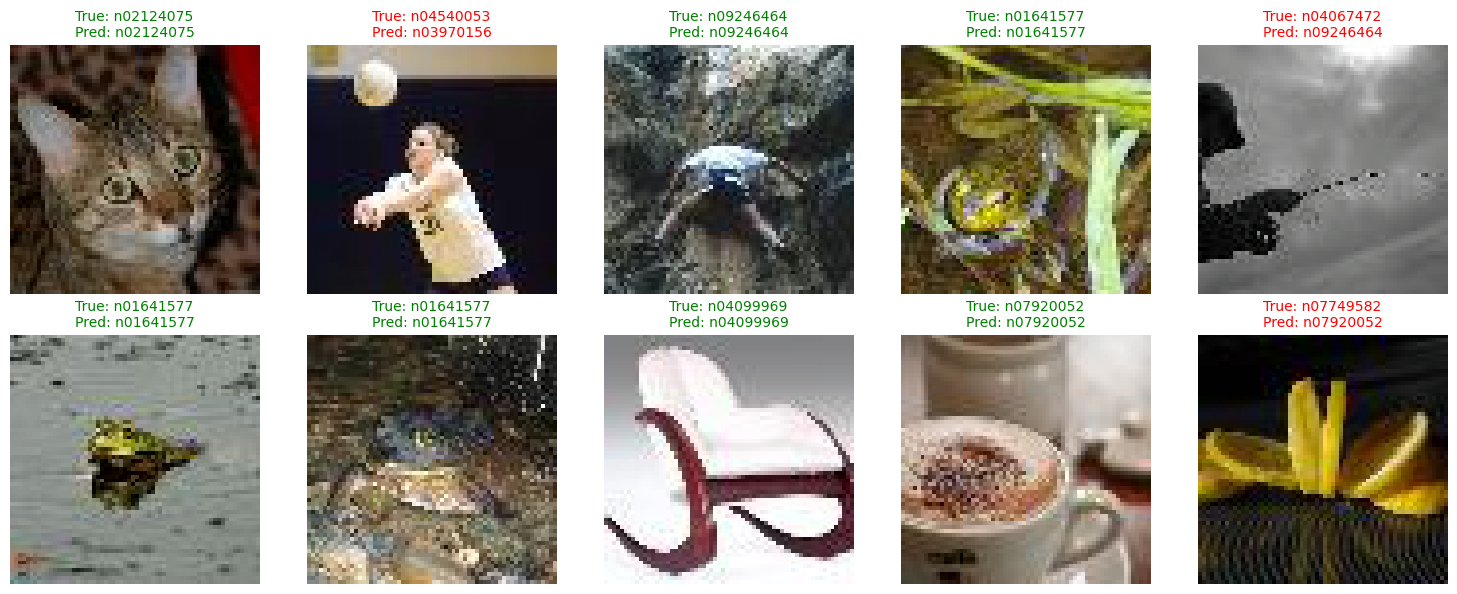

In [109]:
def visualize_predictions(model, dataset, device, num_images=10):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    
    plt.figure(figsize=(15, 6))
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        input_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            _, pred_idx = torch.max(output, 1)
            
        pred_label = dataset.class_names[pred_idx.item()]
        true_label = dataset.class_names[label]
        ax = plt.subplot(2, 5, i + 1)
        img_show = inv_normalize(image).permute(1, 2, 0).numpy()
        img_show = np.clip(img_show, 0, 1)
        plt.imshow(img_show)
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()
visualize_predictions(model, val_dataset, device)

| Этап | Конфигурация | Параметры (M) | Val Accuracy (Best) | Train Accuracy (Last) | Разница (Train - Val) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Baseline | ResNet18 Каналы: 64→128→256 (3 слоя) | 2.7 | 67%  | 79.92% | 12.92% |
| 3.1-A | ResNet18A | 2.79 M | 64.60% | 97.30% | 32.7% |
| 3.1-B (Base) | ResNet18B | 2.77 M | 67% | 79.92% | 12.92% |
| 3.2-A | Блоки: [1, 1, 1, 1] (Мелкая) | 1.227 | 65.00% | 89.98% | 24.98% |
| 3.2-B | Блоки: [2, 2, 2, 2] (Стандарт) | 2.7 | 66.40% | 85.52% | 19.12% |
| 3.2-C | Блоки: [3, 3, 3, 3] (Глубокая) | 4.327 | 66.00% | 86.08% | 20.08% |
| 3.3-A | Активация: ReLU (База) | 2.7 | 66.40% | 85.52% | 19.12% |
| 3.3-B | Активация: LeakyReLU | 2.7 | 67.20% | 91.02% | 23.82% |
| 3.3-C | Активация: ELU | 2.7 | 68.40% | 91.42% | 23.02% |
| 3.3-D | Активация: GELU | 2.7 | 65.40% | 91.24% | 25.84% |
| Final | ELU, [2,2,2,2], 64→128→256 | 2.7 | 68.40% | 91.42% | 23.02%  |

Признаки переобучения присутствуют практически во всех экспериментальных моделях (3.1-A, 3.2-A, 3.3-B, 3.3-C, 3.3-D), где разница между Train Acc и Val Acc находится в диапазоне 20–33%